In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
sns.set_theme(style="whitegrid")

In [4]:
# Carregar dados
try:
    df = pd.read_csv('student-mat.csv', sep=';')
    print(f"Dados carregados: {len(df)} estudantes")
except FileNotFoundError:
    print("Arquivo não encontrado!")
    exit()


# Calcular média das notas
df['G_mean'] = df[['G1', 'G2', 'G3']].mean(axis=1)

# Método 1: Categorização por média geral
overall_mean = df['G_mean'].mean()
df['desempenho_media'] = np.where(df['G_mean'] < overall_mean, 'Abaixo da Média', 'Acima da Média')

# Método 2: Categorização por percentis (divide os alunos em 3 grupos de tamanho igual)
df['desempenho_percentil'] = pd.qcut(df['G_mean'],
                                     q=3,
                                     labels=['Baixo (33%)', 'Médio (33%)', 'Alto (33%)'])

# Método 3: Categorização por critério específico (nota >= 14, ou 70% de 20)
nota_limite = 14
df['acima_70_porcento'] = np.where(df['G_mean'] >= nota_limite, 'Sim', 'Não')

# Estatísticas descritivas
print(f"\nEstatísticas das notas:")
print(f"Média geral: {df['G_mean'].mean():.2f}")
print(f"Desvio padrão: {df['G_mean'].std():.2f}")
print(f"Mínimo: {df['G_mean'].min():.2f}")
print(f"Máximo: {df['G_mean'].max():.2f}")

Dados carregados: 395 estudantes

Estatísticas das notas:
Média geral: 10.68
Desvio padrão: 3.70
Mínimo: 1.33
Máximo: 19.33


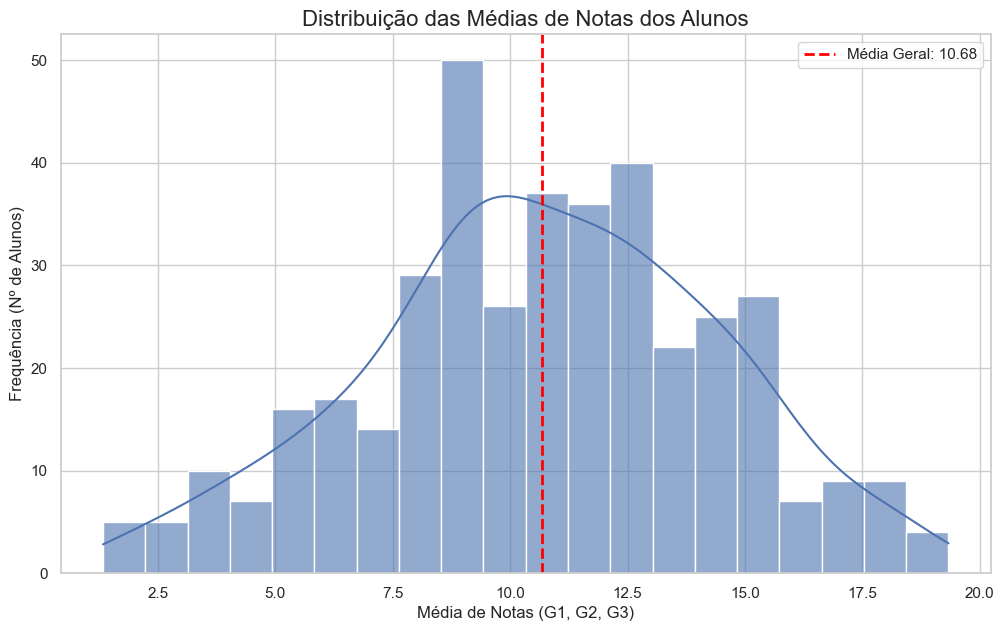

In [23]:
plt.figure(figsize=(12, 7))

# Cria o histograma das médias de notas individuais (G_mean)
# O argumento kde=True adiciona uma linha de estimativa de densidade suave sobre o gráfico
sns.histplot(data=df, x='G_mean', kde=True, bins=20, alpha=0.6)

# Adiciona uma linha vertical para marcar a média geral
plt.axvline(x=overall_mean, color='red', linestyle='--', linewidth=2, label=f'Média Geral: {overall_mean:.2f}')

# Adiciona títulos e legendas para maior clareza
plt.title('Distribuição das Médias de Notas dos Alunos', fontsize=16)
plt.xlabel('Média de Notas (G1, G2, G3)', fontsize=12)
plt.ylabel('Frequência (Nº de Alunos)', fontsize=12)
plt.legend() # Exibe a legenda, incluindo o texto da linha da média

# Mostra o gráfico
plt.show()


ANÁLISE 1: DISTRIBUIÇÃO POR Nº DE REPROVAÇÕES ANTERIORES
          Total_Alunos  Média_Notas  Desvio_Padrão  Qtd_Acima_70%  %_Acima_70%
failures                                                                      
0                  312        11.36           3.48             78         25.0
1                   50         8.98           3.36              2          4.0
2                   17         7.31           3.52              1          5.9
3                   16         6.35           2.47              0          0.0

TESTE QUI-QUADRADO: REPROVAÇÕES vs. DESEMPENHO
Tabela de Contingência (Reprovações vs Desempenho por Percentil):
desempenho_percentil  Baixo (33%)  Médio (33%)  Alto (33%)
failures                                                  
0                              76          118         118
1                              26           17           7
2                              14            1           2
3                              16            0           0


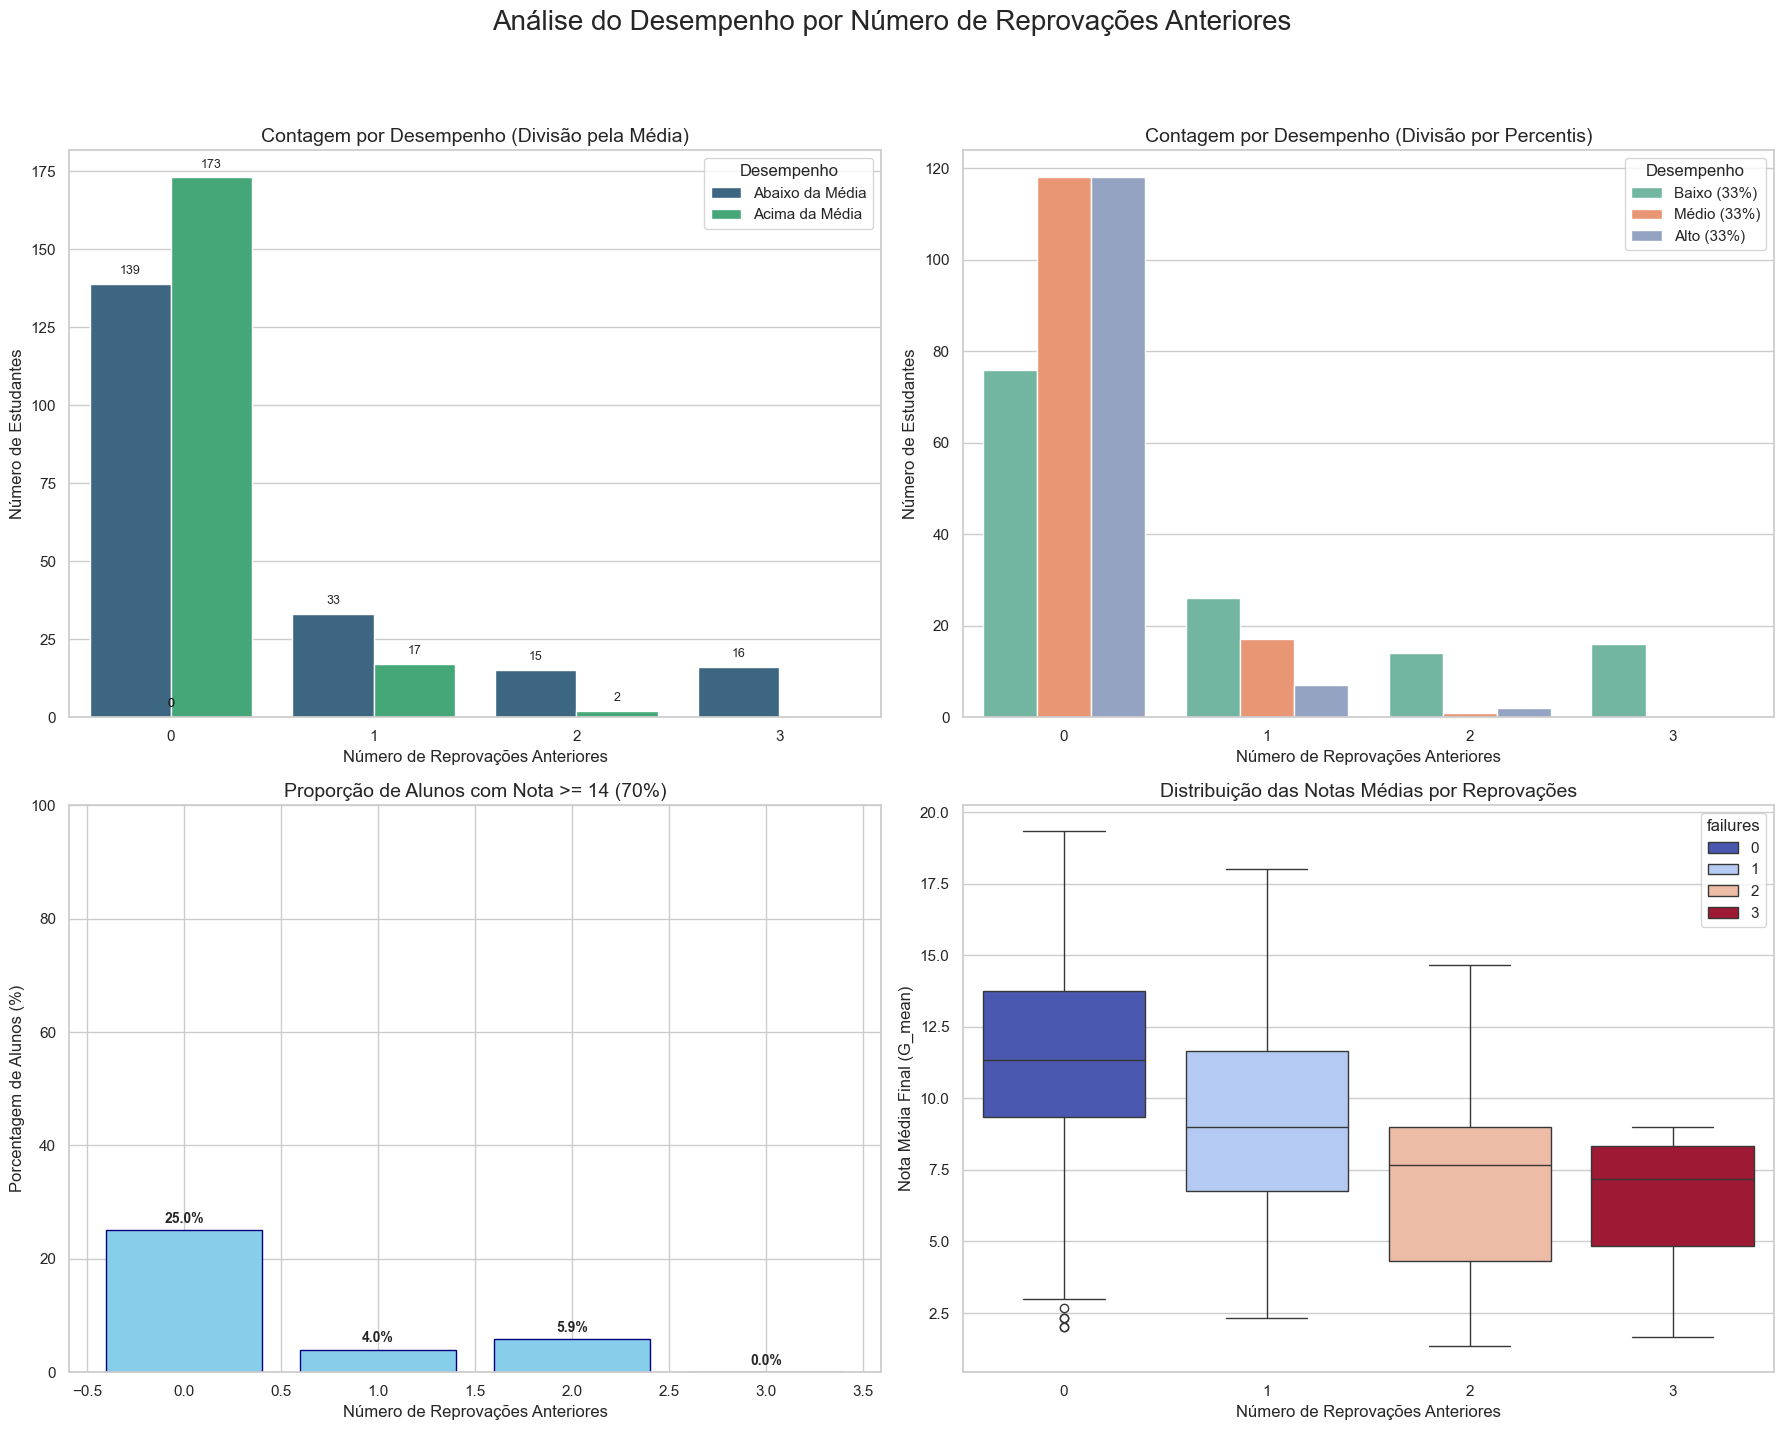


RESUMO DA ANÁLISE: REPROVAÇÕES vs. DESEMPENHO
• A análise focou na relação entre o número de reprovações anteriores (`failures`) e o desempenho acadêmico.
• A média de notas decai consistentemente com o aumento do número de reprovações:
  - 0 Reprovações: Média 11.36
  - 3 Reprovações: Média 6.35
• A porcentagem de alunos com nota acima de 14 (70%) é drasticamente menor para quem já reprovou:
  - 0 Reprovações: 25.0% dos alunos tiveram nota >= 14.
  - 1 ou mais reprovações: Apenas 5.9% ou menos tiveram nota >= 14.
• O Teste Qui-Quadrado (p-valor = 0.0000) confirma que a associação entre reprovações e desempenho é estatisticamente SIGNIFICATIVA.
• Conclusão: O histórico de reprovações é um forte preditor de desempenho acadêmico futuro neste conjunto de dados.


In [29]:
# Tabela descritiva
print("\n" + "="*60)
print("ANÁLISE 1: DISTRIBUIÇÃO POR Nº DE REPROVAÇÕES ANTERIORES")
print("="*60)

analise_reprovacoes = df.groupby('failures').agg({
    'G_mean': ['count', 'mean', 'std'],
    'acima_70_porcento': lambda x: (x == 'Sim').sum()
}).round(2)

analise_reprovacoes.columns = ['Total_Alunos', 'Média_Notas', 'Desvio_Padrão', 'Qtd_Acima_70%']
analise_reprovacoes['%_Acima_70%'] = (analise_reprovacoes['Qtd_Acima_70%'] / analise_reprovacoes['Total_Alunos'] * 100).round(1)
print(analise_reprovacoes)

# Teste Qui-Quadrado para verificar a associação estatística
print("\n" + "="*60)
print("TESTE QUI-QUADRADO: REPROVAÇÕES vs. DESEMPENHO")
print("="*60)

contingency_table = pd.crosstab(df['failures'], df['desempenho_percentil'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Tabela de Contingência (Reprovações vs Desempenho por Percentil):")
print(contingency_table)
print(f"\nEstatística Qui-Quadrado: {chi2:.4f}")
print(f"Valor p: {p_value:.4f}")
print(f"Graus de liberdade: {dof}")

if p_value < 0.05:
    print("\n✅ Há uma associação ESTATISTICAMENTE SIGNIFICATIVA entre o número de reprovações e o desempenho do aluno (p < 0.05).")
else:
    print("\n❌ NÃO há associação significativa entre o número de reprovações e o desempenho do aluno (p ≥ 0.05).")



fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análise do Desempenho por Número de Reprovações Anteriores', fontsize=20, y=1.02)

# Gráfico 1: Contagem por Desempenho (Média Geral)
ax1 = axes[0, 0]
sns.countplot(data=df, x='failures', hue='desempenho_media', ax=ax1, palette='viridis')
ax1.set_title('Contagem por Desempenho (Divisão pela Média)', fontsize=14)
ax1.set_xlabel('Número de Reprovações Anteriores', fontsize=12)
ax1.set_ylabel('Número de Estudantes', fontsize=12)
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=9, xytext=(0, 5), textcoords='offset points')
ax1.legend(title='Desempenho')

# Gráfico 2: Contagem por Desempenho (Percentis)
ax2 = axes[0, 1]
sns.countplot(data=df, x='failures', hue='desempenho_percentil', ax=ax2, palette='Set2')
ax2.set_title('Contagem por Desempenho (Divisão por Percentis)', fontsize=14)
ax2.set_xlabel('Número de Reprovações Anteriores', fontsize=12)
ax2.set_ylabel('Número de Estudantes', fontsize=12)
ax2.legend(title='Desempenho')

# Gráfico 3: Proporção de Alunos com Nota Acima de 70%
ax3 = axes[1, 0]
prop_data = df.groupby('failures')['acima_70_porcento'].apply(lambda x: (x == 'Sim').mean() * 100).fillna(0)
bars = ax3.bar(prop_data.index, prop_data.values, color='skyblue', edgecolor='navy')
ax3.set_title('Proporção de Alunos com Nota >= 14 (70%)', fontsize=14)
ax3.set_xlabel('Número de Reprovações Anteriores', fontsize=12)
ax3.set_ylabel('Porcentagem de Alunos (%)', fontsize=12)
ax3.set_ylim(0, 100)
for bar in bars:
    height = bar.get_height()
    ax3.annotate(f'{height:.1f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points",
                 ha='center', va='bottom', fontsize=10, weight='bold')

# Gráfico 4: Boxplot da Distribuição das Notas Médias
ax4 = axes[1, 1]
sns.boxplot(data=df, x='failures', y='G_mean', hue='failures', ax=ax4, palette='coolwarm')
ax4.set_title('Distribuição das Notas Médias por Reprovações', fontsize=14)
ax4.set_xlabel('Número de Reprovações Anteriores', fontsize=12)
ax4.set_ylabel('Nota Média Final (G_mean)', fontsize=12)

# Ajusta o layout para evitar sobreposição e exibe os gráficos
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


# --------------------------------------------------------------------------
# 4. RESUMO FINAL DA ANÁLISE
# Impressão das conclusões principais
# --------------------------------------------------------------------------
print("\n" + "="*60)
print("RESUMO DA ANÁLISE: REPROVAÇÕES vs. DESEMPENHO")
print("="*60)
print(f"• A análise focou na relação entre o número de reprovações anteriores (`failures`) e o desempenho acadêmico.")
print(f"• A média de notas decai consistentemente com o aumento do número de reprovações:")
print(f"  - 0 Reprovações: Média {analise_reprovacoes.loc[0, 'Média_Notas']:.2f}")
print(f"  - 3 Reprovações: Média {analise_reprovacoes.loc[3, 'Média_Notas']:.2f}")
print(f"• A porcentagem de alunos com nota acima de 14 (70%) é drasticamente menor para quem já reprovou:")
print(f"  - 0 Reprovações: {analise_reprovacoes.loc[0, '%_Acima_70%']:.1f}% dos alunos tiveram nota >= 14.")
print(f"  - 1 ou mais reprovações: Apenas {analise_reprovacoes.loc[1:, '%_Acima_70%'].max():.1f}% ou menos tiveram nota >= 14.")
print(f"• O Teste Qui-Quadrado (p-valor = {p_value:.4f}) confirma que a associação entre reprovações e desempenho é estatisticamente SIGNIFICATIVA.")
print("• Conclusão: O histórico de reprovações é um forte preditor de desempenho acadêmico futuro neste conjunto de dados.")


ANÁLISE 1: DISTRIBUIÇÃO POR TEMPO DE ESTUDO SEMANAL
           Total_Alunos  Média_Notas  Desvio_Padrão  Qtd_Acima_70%  \
studytime                                                            
1                   105        10.25           4.14             18   
2                   198        10.44           3.38             37   
3                    65        11.65           3.66             18   
4                    27        11.73           3.82              8   

           %_Acima_70%  
studytime               
1                 17.1  
2                 18.7  
3                 27.7  
4                 29.6  

TESTE QUI-QUADRADO: TEMPO DE ESTUDO vs. DESEMPENHO
Tabela de Contingência (Tempo de Estudo vs Desempenho por Percentil):
desempenho_percentil  Baixo (33%)  Médio (33%)  Alto (33%)
studytime                                                 
1                              42           31          32
2                              70           74          54
3                 

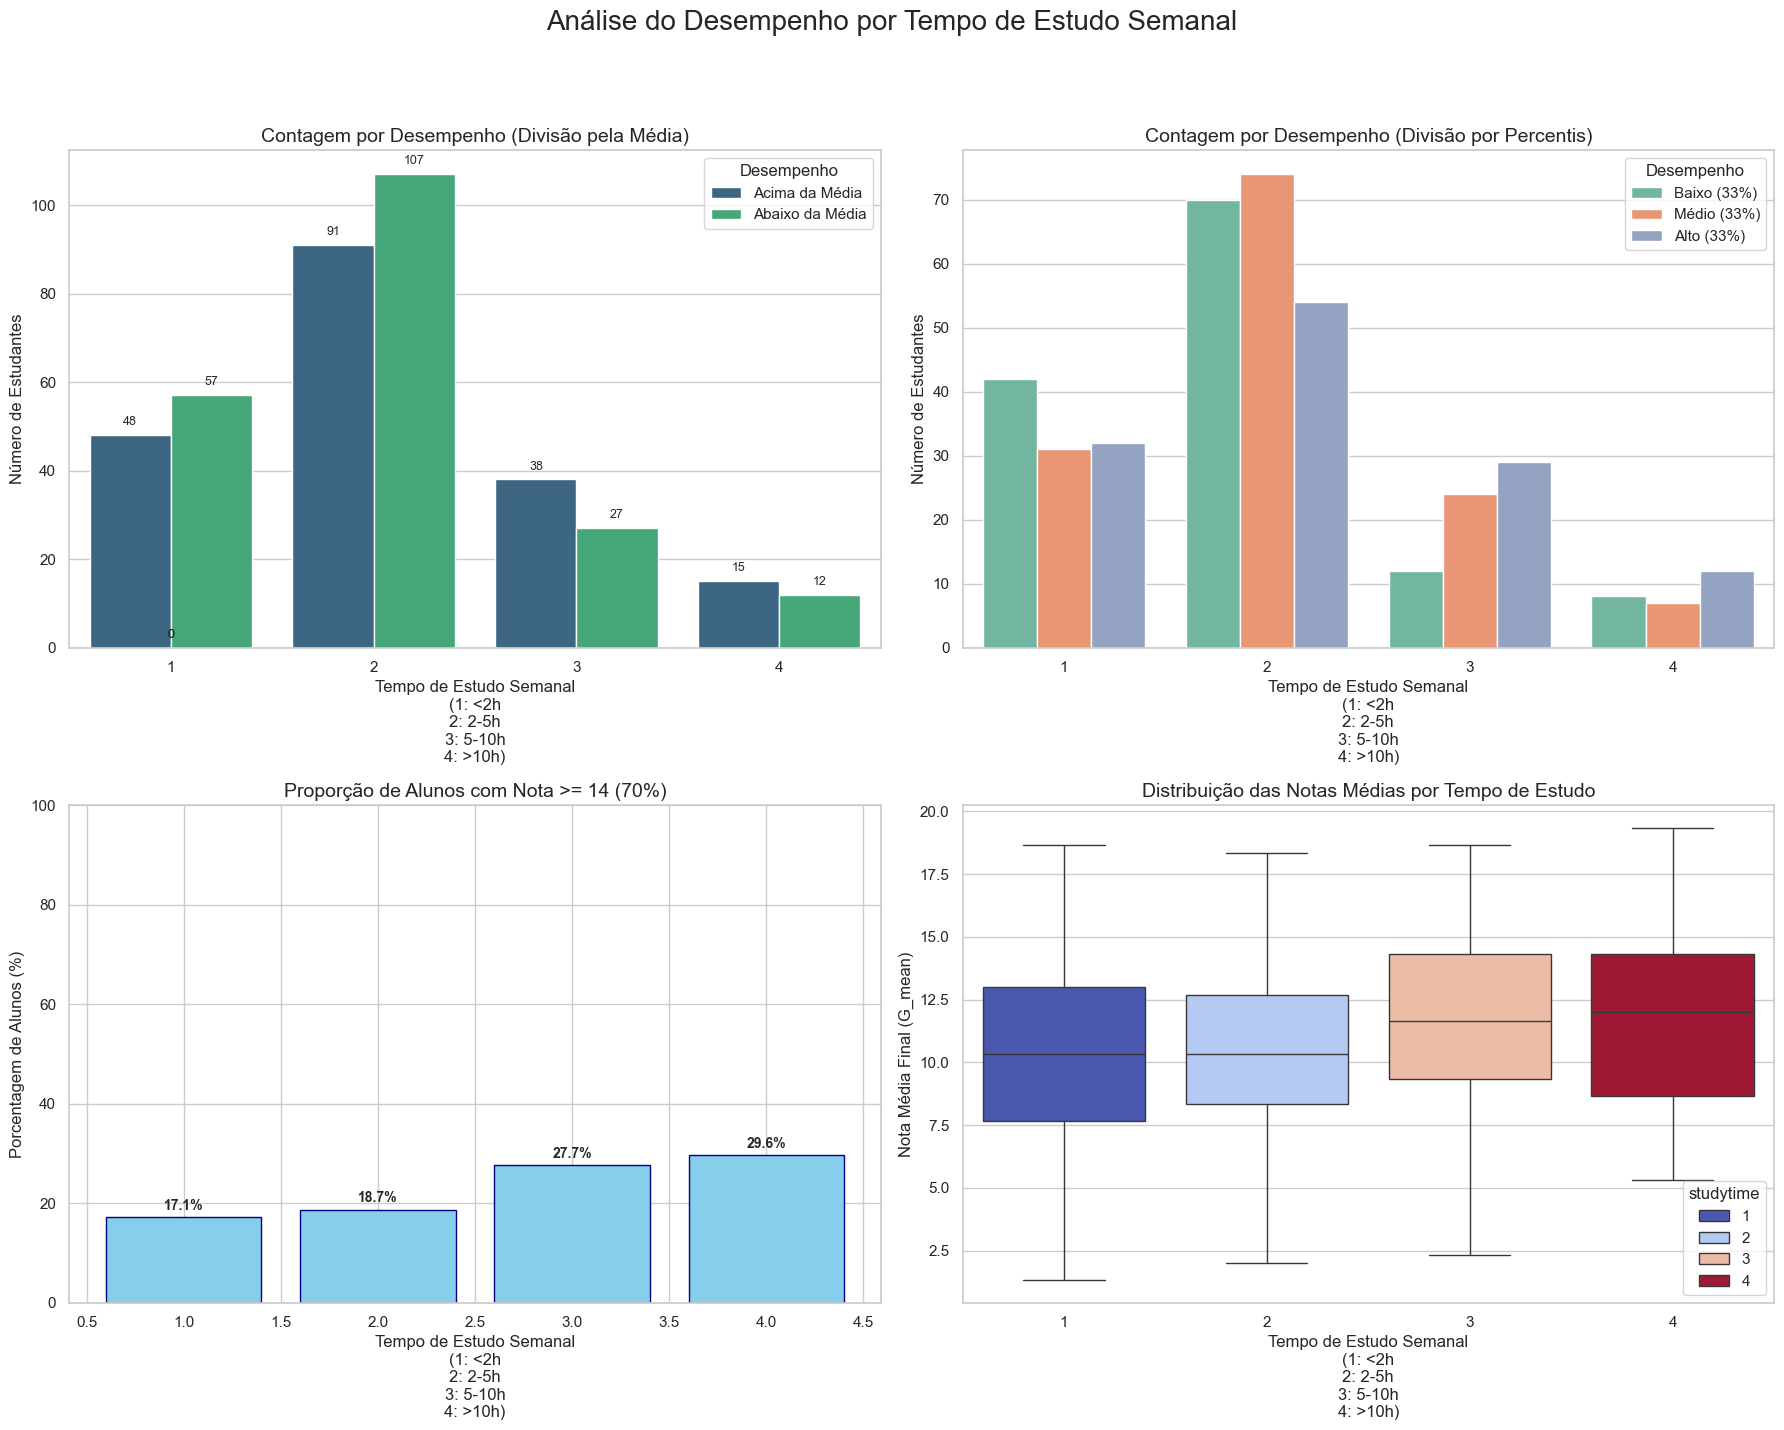

In [30]:
# Tabela descritiva
print("\n" + "="*60)
print("ANÁLISE 1: DISTRIBUIÇÃO POR TEMPO DE ESTUDO SEMANAL")
print("="*60)

analise_tempo_estudo = df.groupby('studytime').agg({
    'G_mean': ['count', 'mean', 'std'],
    'acima_70_porcento': lambda x: (x == 'Sim').sum()
}).round(2)

analise_tempo_estudo.columns = ['Total_Alunos', 'Média_Notas', 'Desvio_Padrão', 'Qtd_Acima_70%']
analise_tempo_estudo['%_Acima_70%'] = (analise_tempo_estudo['Qtd_Acima_70%'] / analise_tempo_estudo['Total_Alunos'] * 100).round(1)
print(analise_tempo_estudo)

# Teste Qui-Quadrado para verificar a associação estatística
print("\n" + "="*60)
print("TESTE QUI-QUADRADO: TEMPO DE ESTUDO vs. DESEMPENHO")
print("="*60)

contingency_table = pd.crosstab(df['studytime'], df['desempenho_percentil'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Tabela de Contingência (Tempo de Estudo vs Desempenho por Percentil):")
print(contingency_table)
print(f"\nEstatística Qui-Quadrado: {chi2:.4f}")
print(f"Valor p: {p_value:.4f}")
print(f"Graus de liberdade: {dof}")

if p_value < 0.05:
    print("\n✅ Há uma associação ESTATISTICAMENTE SIGNIFICATIVA entre o tempo de estudo e o desempenho do aluno (p < 0.05).")
else:
    print("\n❌ NÃO há associação significativa entre o tempo de estudo e o desempenho do aluno (p ≥ 0.05).")


# --------------------------------------------------------------------------
# 3. VISUALIZAÇÕES
# Criação do painel de gráficos 2x2
# --------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análise do Desempenho por Tempo de Estudo Semanal', fontsize=20, y=1.02)

# Rótulos descritivos para o eixo X, conforme solicitado
studytime_labels = '1: <2h\n2: 2-5h\n3: 5-10h\n4: >10h'

# Gráfico 1: Contagem por Desempenho (Média Geral)
ax1 = axes[0, 0]
sns.countplot(data=df, x='studytime', hue='desempenho_media', ax=ax1, palette='viridis')
ax1.set_title('Contagem por Desempenho (Divisão pela Média)', fontsize=14)
ax1.set_xlabel(f'Tempo de Estudo Semanal\n({studytime_labels})', fontsize=12)
ax1.set_ylabel('Número de Estudantes', fontsize=12)
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=9, xytext=(0, 5), textcoords='offset points')
ax1.legend(title='Desempenho')

# Gráfico 2: Contagem por Desempenho (Percentis)
ax2 = axes[0, 1]
sns.countplot(data=df, x='studytime', hue='desempenho_percentil', ax=ax2, palette='Set2')
ax2.set_title('Contagem por Desempenho (Divisão por Percentis)', fontsize=14)
ax2.set_xlabel(f'Tempo de Estudo Semanal\n({studytime_labels})', fontsize=12)
ax2.set_ylabel('Número de Estudantes', fontsize=12)
ax2.legend(title='Desempenho')

# Gráfico 3: Proporção de Alunos com Nota Acima de 70%
ax3 = axes[1, 0]
prop_data = df.groupby('studytime')['acima_70_porcento'].apply(lambda x: (x == 'Sim').mean() * 100).fillna(0)
bars = ax3.bar(prop_data.index, prop_data.values, color='skyblue', edgecolor='navy')
ax3.set_title('Proporção de Alunos com Nota >= 14 (70%)', fontsize=14)
ax3.set_xlabel(f'Tempo de Estudo Semanal\n({studytime_labels})', fontsize=12)
ax3.set_ylabel('Porcentagem de Alunos (%)', fontsize=12)
ax3.set_ylim(0, 100)
for bar in bars:
    height = bar.get_height()
    ax3.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, weight='bold')

# Gráfico 4: Boxplot da Distribuição das Notas Médias
ax4 = axes[1, 1]
sns.boxplot(data=df, x='studytime', y='G_mean', hue='studytime', ax=ax4, palette='coolwarm')
ax4.set_title('Distribuição das Notas Médias por Tempo de Estudo', fontsize=14)
ax4.set_xlabel(f'Tempo de Estudo Semanal\n({studytime_labels})', fontsize=12)
ax4.set_ylabel('Nota Média Final (G_mean)', fontsize=12)

# Ajusta o layout para evitar sobreposição e exibe os gráficos
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('analise_tempo_estudo.png', dpi=300, bbox_inches='tight') # Salva a imagem
plt.show() # Exibe os gráficos

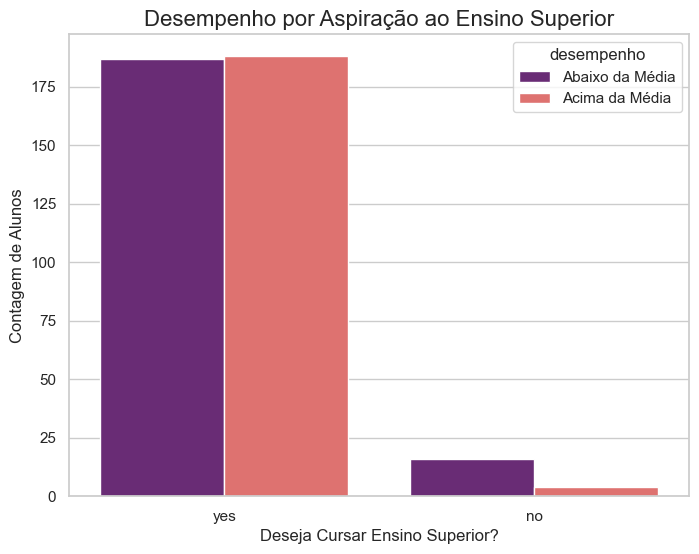

In [6]:
# 3. Comparação por Aspiração ao Ensino Superior (higher)
plt.figure(figsize=(8, 6))
sns.countplot(x='higher', hue='desempenho', data=df, palette='magma')
plt.title('Desempenho por Aspiração ao Ensino Superior', fontsize=16)
plt.xlabel('Deseja Cursar Ensino Superior?', fontsize=12)
plt.ylabel('Contagem de Alunos', fontsize=12)
plt.show()

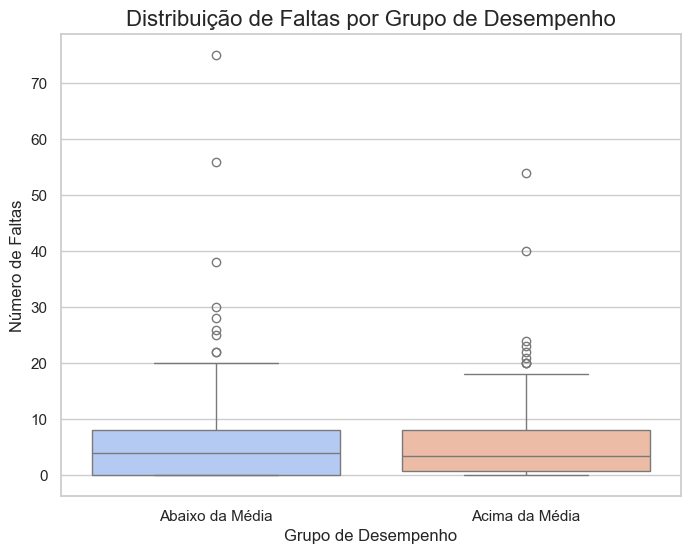

In [8]:
# 4. Comparação do Número de Faltas (absences)
plt.figure(figsize=(8, 6))
sns.boxplot(x='desempenho', y='absences', data=df, hue='desempenho', palette='coolwarm', legend=False)
plt.title('Distribuição de Faltas por Grupo de Desempenho', fontsize=16)
plt.xlabel('Grupo de Desempenho', fontsize=12)
plt.ylabel('Número de Faltas', fontsize=12)
plt.show()

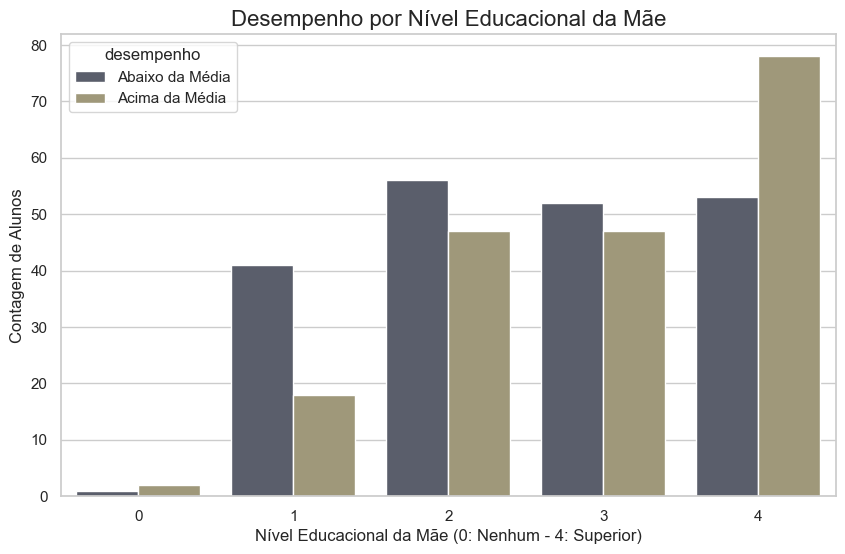

In [9]:
# 5. Comparação por Nível Educacional da Mãe (Medu)
plt.figure(figsize=(10, 6))
sns.countplot(x='Medu', hue='desempenho', data=df, palette='cividis')
plt.title('Desempenho por Nível Educacional da Mãe', fontsize=16)
plt.xlabel('Nível Educacional da Mãe (0: Nenhum - 4: Superior)', fontsize=12)
plt.ylabel('Contagem de Alunos', fontsize=12)
plt.show()


ANÁLISE 1: DISTRIBUIÇÃO POR FAIXA DE FALTAS
              Total_Alunos  Média_Notas  Desvio_Padrão
faixa_faltas                                          
0 Faltas               115         9.63           4.71
1-5 Faltas             134        11.49           2.98
6-10 Faltas             80        11.17           3.21
11-20 Faltas            51        10.24           2.95
>20 Faltas              15        10.44           3.60

TESTE QUI-QUADRADO: FAIXA DE FALTAS vs. DESEMPENHO
Tabela de Contingência (Faixa de Faltas vs Desempenho por Percentil):
desempenho_percentil  Baixo (33%)  Médio (33%)  Alto (33%)
faixa_faltas                                              
0 Faltas                       51           23          41
1-5 Faltas                     32           55          47
6-10 Faltas                    24           30          26
11-20 Faltas                   19           22          10
>20 Faltas                      6            6           3

Estatística Qui-Quadrado: 22.5744


C:\Users\diego\AppData\Local\Temp\ipykernel_1548\1305350547.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analise_faltas = df.groupby('faixa_faltas').agg({


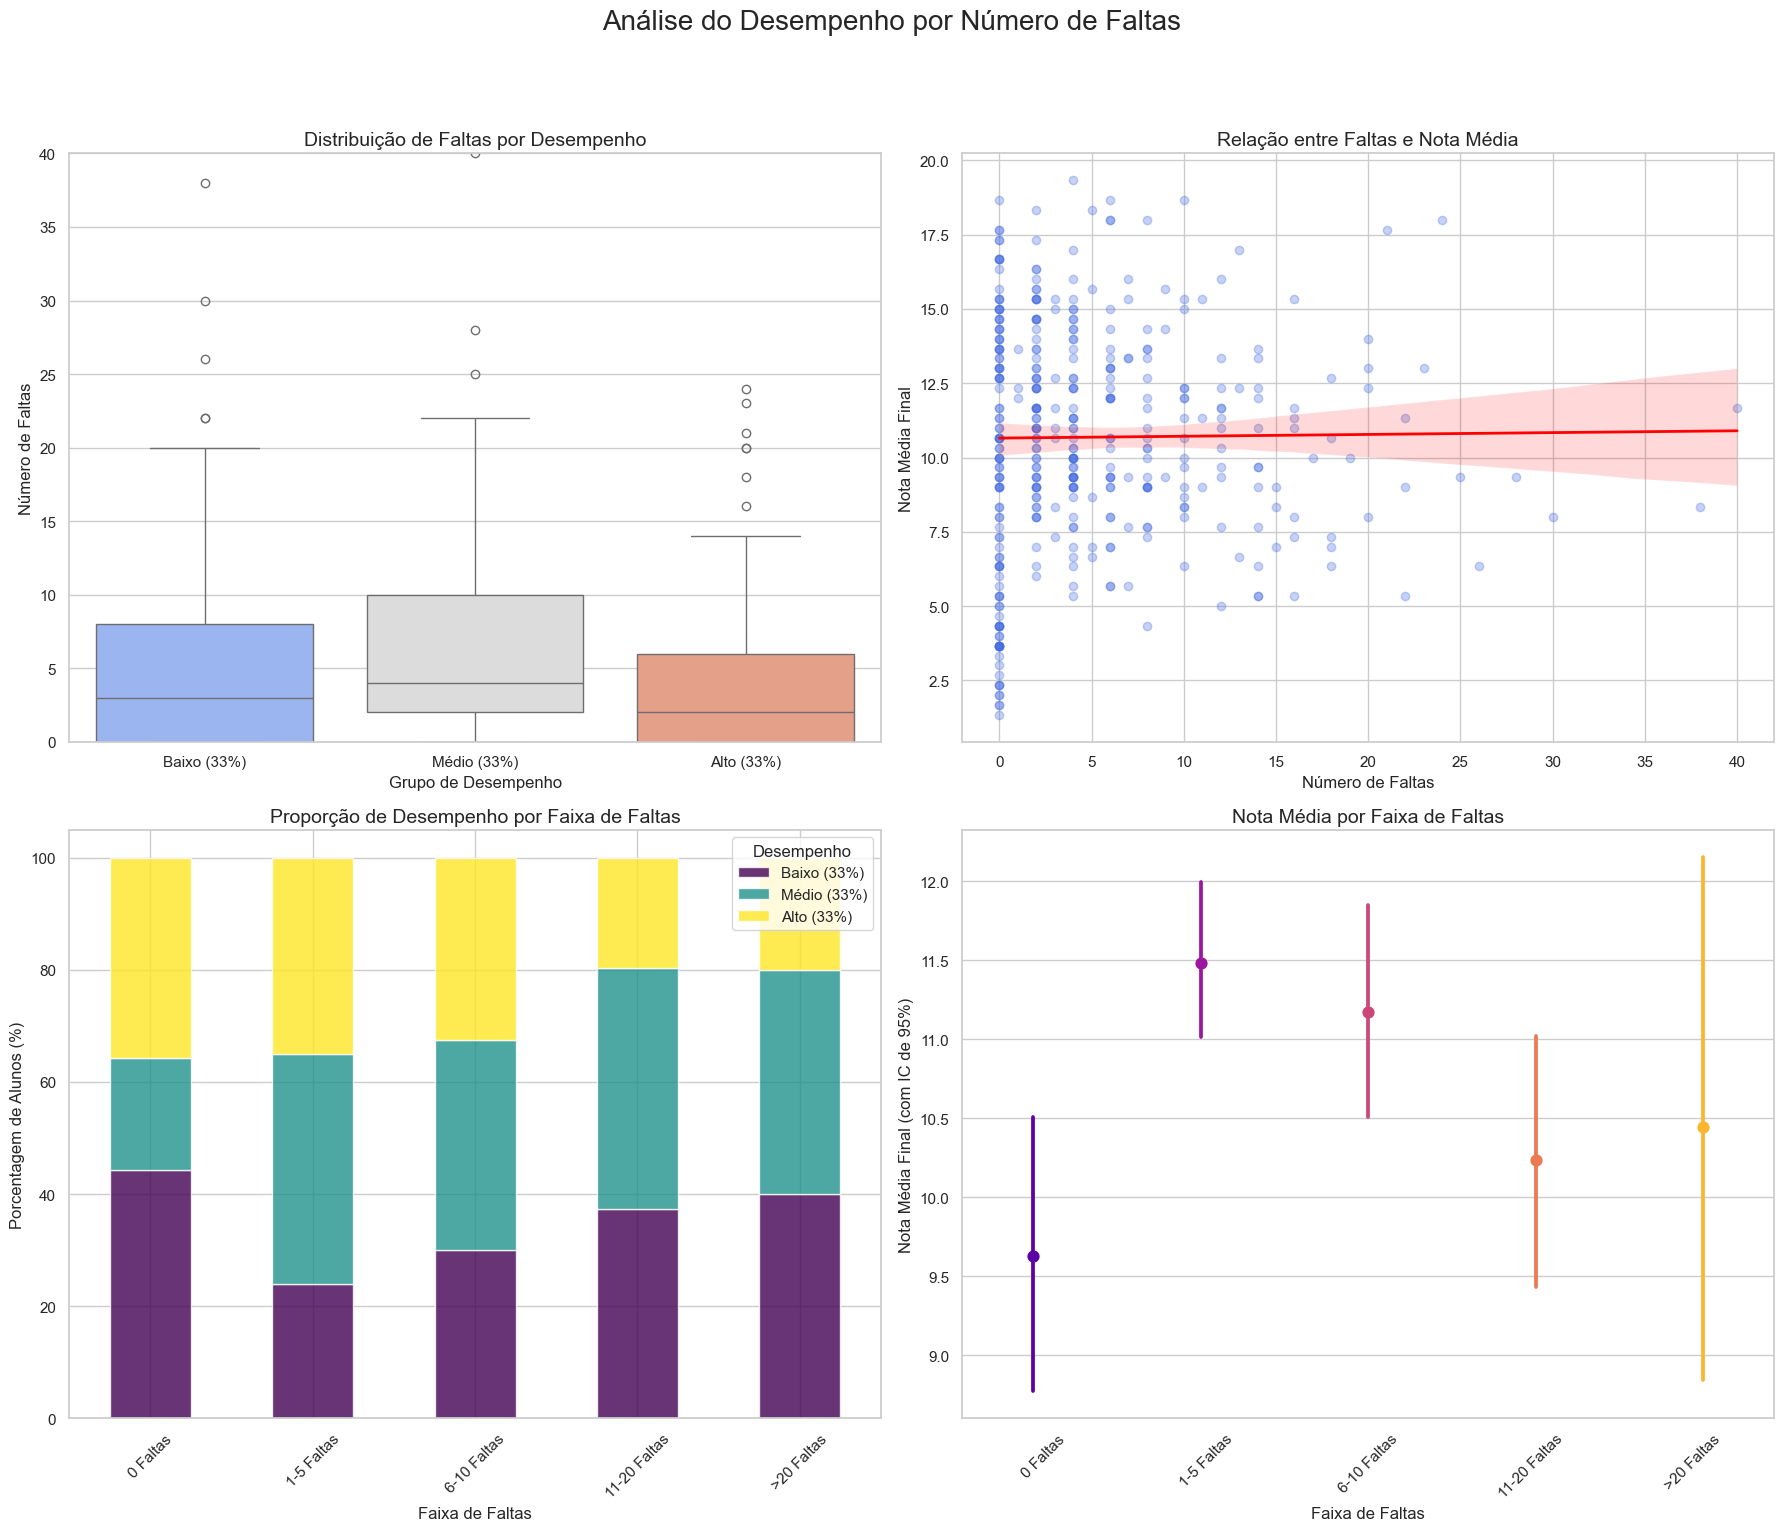

In [32]:
# Criando faixas de faltas para melhor agrupamento, pois 'absences' é contínua
bins = [-1, 0, 5, 10, 20, 100]  # Limites das faixas
labels = ['0 Faltas', '1-5 Faltas', '6-10 Faltas', '11-20 Faltas', '>20 Faltas'] # Rótulos
df['faixa_faltas'] = pd.cut(df['absences'], bins=bins, labels=labels)

# Tabela descritiva
print("\n" + "="*60)
print("ANÁLISE 1: DISTRIBUIÇÃO POR FAIXA DE FALTAS")
print("="*60)

analise_faltas = df.groupby('faixa_faltas').agg({
    'G_mean': ['count', 'mean', 'std'],
}).round(2)
analise_faltas.columns = ['Total_Alunos', 'Média_Notas', 'Desvio_Padrão']
print(analise_faltas)

# Teste Qui-Quadrado para verificar a associação estatística
print("\n" + "="*60)
print("TESTE QUI-QUADRADO: FAIXA DE FALTAS vs. DESEMPENHO")
print("="*60)

contingency_table = pd.crosstab(df['faixa_faltas'], df['desempenho_percentil'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Tabela de Contingência (Faixa de Faltas vs Desempenho por Percentil):")
print(contingency_table)
print(f"\nEstatística Qui-Quadrado: {chi2:.4f}")
print(f"Valor p: {p_value:.4f}")
print(f"Graus de liberdade: {dof}")

if p_value < 0.05:
    print("\n✅ Há uma associação ESTATISTICAMENTE SIGNIFICATIVA entre a faixa de faltas e o desempenho do aluno (p < 0.05).")
else:
    print("\n❌ NÃO há associação significativa entre a faixa de faltas e o desempenho do aluno (p ≥ 0.05).")


# --------------------------------------------------------------------------
# 3. VISUALIZAÇÕES
# Criação do painel de gráficos 2x2 adaptado para a variável 'absences'
# --------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
fig.suptitle('Análise do Desempenho por Número de Faltas', fontsize=20, y=1.02)

# Gráfico 1: Boxplot (versão melhorada da sugestão original)
sns.boxplot(ax=axes[0, 0], data=df, x='desempenho_percentil', y='absences', hue='desempenho_percentil', palette='coolwarm')
axes[0, 0].set_title('Distribuição de Faltas por Desempenho', fontsize=14)
axes[0, 0].set_xlabel('Grupo de Desempenho', fontsize=12)
axes[0, 0].set_ylabel('Número de Faltas', fontsize=12)
axes[0, 0].set_ylim(0, 40) # Limitar eixo Y para melhor visualização dos boxplots

# Gráfico 2: Gráfico de Regressão para ver a tendência
# Filtrar faltas extremas (>40) para não distorcer a visualização da linha de tendência
df_filtered = df[df['absences'] <= 40]
sns.regplot(ax=axes[0, 1], data=df_filtered, x='absences', y='G_mean',
            scatter_kws={'alpha':0.3, 'color':'royalblue'}, line_kws={'color':'red', 'linewidth':2})
axes[0, 1].set_title('Relação entre Faltas e Nota Média', fontsize=14)
axes[0, 1].set_xlabel('Número de Faltas', fontsize=12)
axes[0, 1].set_ylabel('Nota Média Final', fontsize=12)

# Gráfico 3: Gráfico de Barras Proporcional (empilhado)
prop_data = pd.crosstab(df['faixa_faltas'], df['desempenho_percentil'], normalize='index') * 100
prop_data.plot(kind='bar', stacked=True, ax=axes[1, 0], colormap='viridis', alpha=0.8)
axes[1, 0].set_title('Proporção de Desempenho por Faixa de Faltas', fontsize=14)
axes[1, 0].set_xlabel('Faixa de Faltas', fontsize=12)
axes[1, 0].set_ylabel('Porcentagem de Alunos (%)', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend(title='Desempenho')

# Gráfico 4: Gráfico de Pontos com Intervalo de Confiança
sns.pointplot(ax=axes[1, 1], data=df, x='faixa_faltas', y='G_mean', hue='faixa_faltas', palette='plasma', dodge=True)
axes[1, 1].set_title('Nota Média por Faixa de Faltas', fontsize=14)
axes[1, 1].set_xlabel('Faixa de Faltas', fontsize=12)
axes[1, 1].set_ylabel('Nota Média Final (com IC de 95%)', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)

# Ajusta o layout para evitar sobreposição e exibe os gráficos
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('analise_faltas.png', dpi=300, bbox_inches='tight')
plt.show()


ANÁLISE 1: DISTRIBUIÇÃO POR SUPORTE ESCOLAR EXTRA
           Total_Alunos  Média_Notas  Desvio_Padrão  Qtd_Acima_70%  \
schoolsup                                                            
no                  344        10.88           3.83             80   
yes                  51         9.36           2.28              1   

           %_Acima_70%  
schoolsup               
no                23.3  
yes                2.0  

TESTE QUI-QUADRADO: SUPORTE ESCOLAR vs. DESEMPENHO
Tabela de Contingência (Suporte Escolar vs Desempenho por Percentil):
desempenho_percentil  Baixo (33%)  Médio (33%)  Alto (33%)
schoolsup                                                 
no                            106          116         122
yes                            26           20           5

Estatística Qui-Quadrado: 14.8913
Valor p: 0.0006
Graus de liberdade: 2

✅ Há uma associação ESTATISTICAMENTE SIGNIFICATIVA entre receber suporte escolar e o desempenho do aluno (p < 0.05).


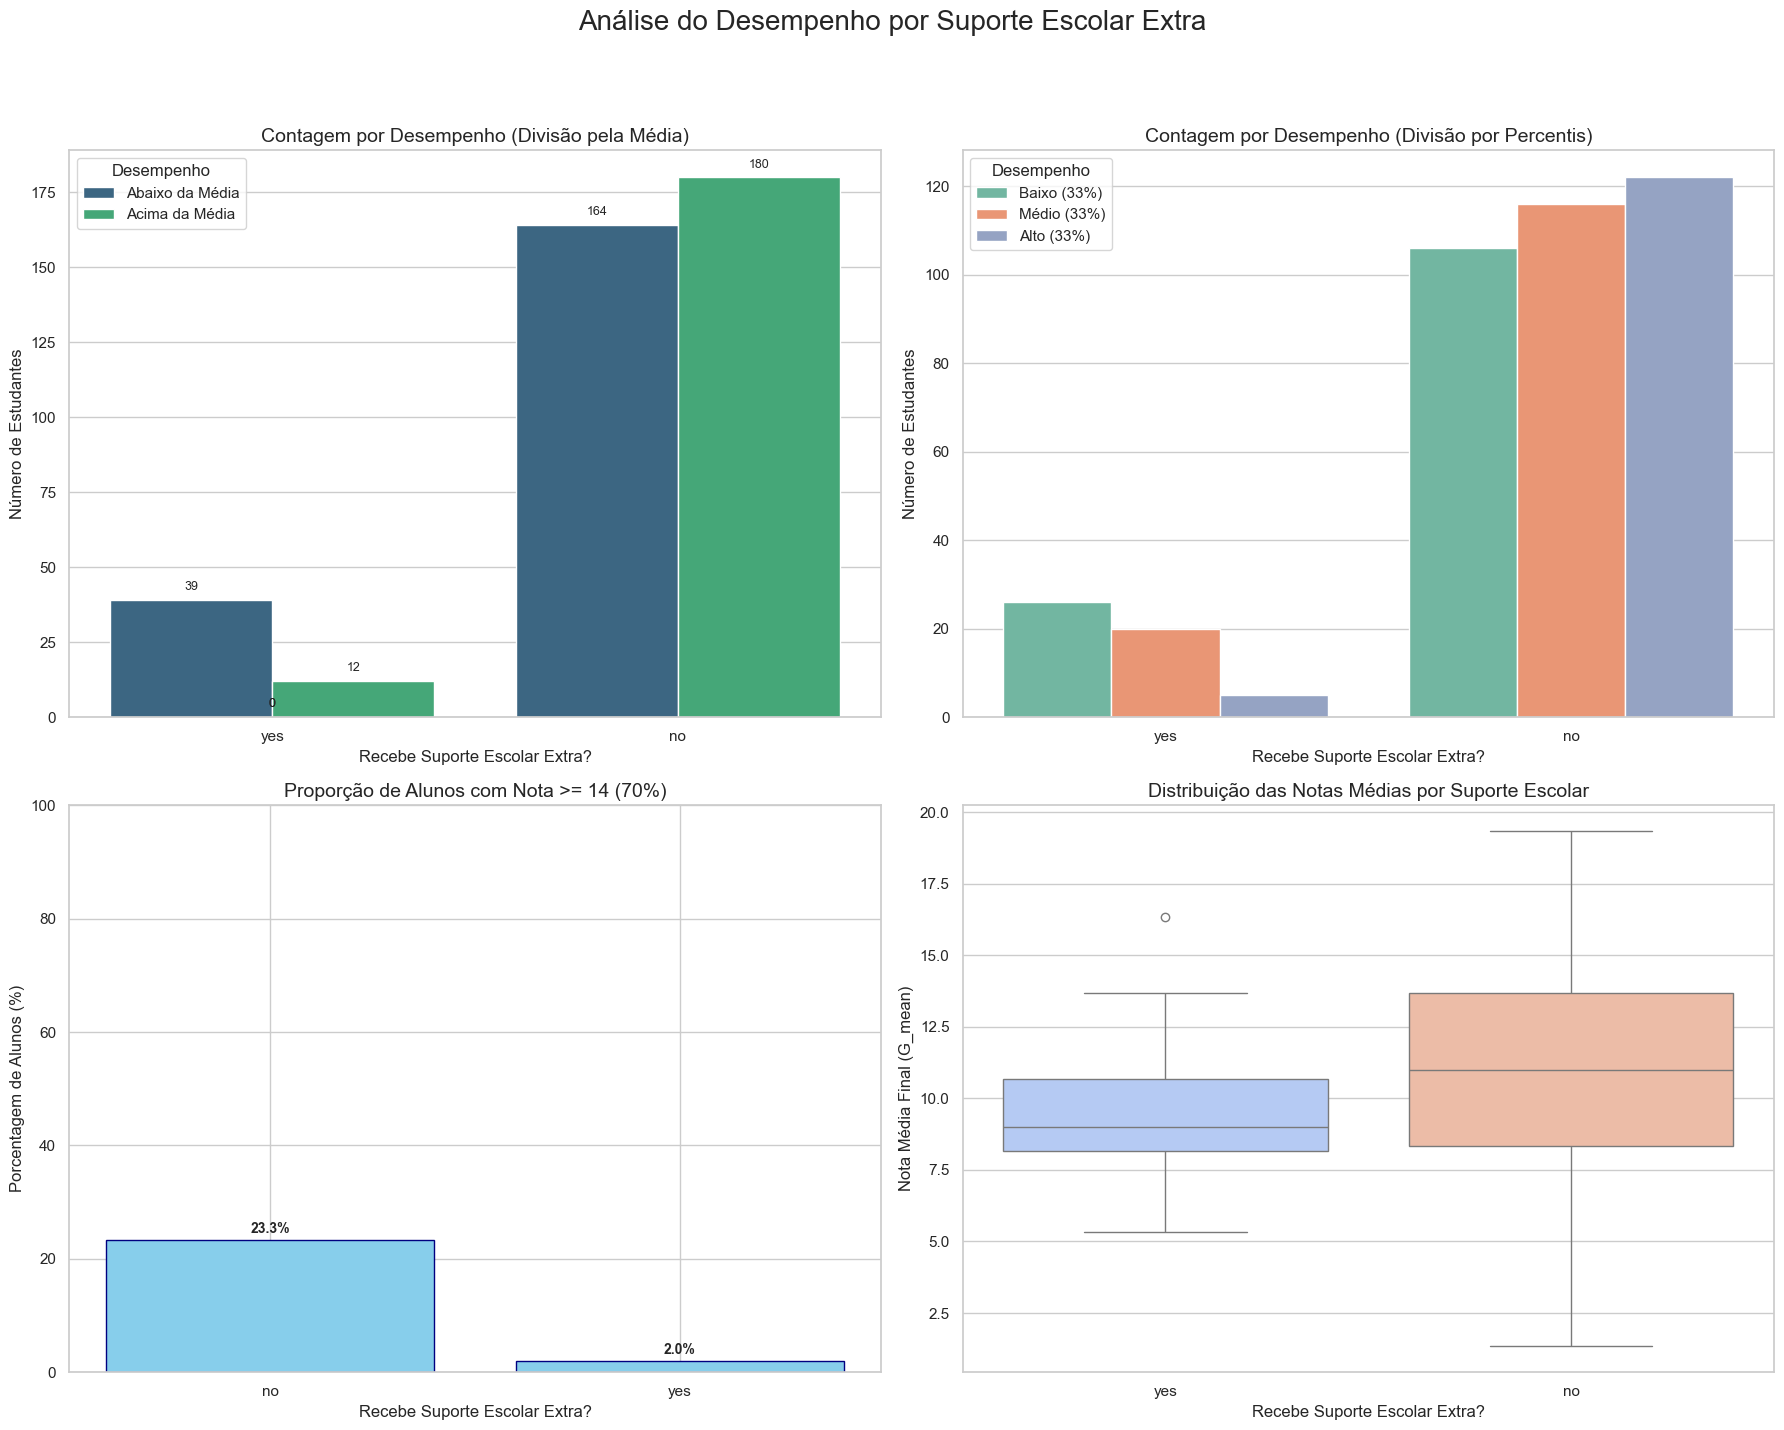

In [33]:
# Tabela descritiva
print("\n" + "="*60)
print("ANÁLISE 1: DISTRIBUIÇÃO POR SUPORTE ESCOLAR EXTRA")
print("="*60)

analise_suporte = df.groupby('schoolsup').agg({
    'G_mean': ['count', 'mean', 'std'],
    'acima_70_porcento': lambda x: (x == 'Sim').sum()
}).round(2)

analise_suporte.columns = ['Total_Alunos', 'Média_Notas', 'Desvio_Padrão', 'Qtd_Acima_70%']
analise_suporte['%_Acima_70%'] = (analise_suporte['Qtd_Acima_70%'] / analise_suporte['Total_Alunos'] * 100).round(1)
print(analise_suporte)

# Teste Qui-Quadrado para verificar a associação estatística
print("\n" + "="*60)
print("TESTE QUI-QUADRADO: SUPORTE ESCOLAR vs. DESEMPENHO")
print("="*60)

contingency_table = pd.crosstab(df['schoolsup'], df['desempenho_percentil'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Tabela de Contingência (Suporte Escolar vs Desempenho por Percentil):")
print(contingency_table)
print(f"\nEstatística Qui-Quadrado: {chi2:.4f}")
print(f"Valor p: {p_value:.4f}")
print(f"Graus de liberdade: {dof}")

if p_value < 0.05:
    print("\n✅ Há uma associação ESTATISTICAMENTE SIGNIFICATIVA entre receber suporte escolar e o desempenho do aluno (p < 0.05).")
else:
    print("\n❌ NÃO há associação significativa entre receber suporte escolar e o desempenho do aluno (p ≥ 0.05).")


# --------------------------------------------------------------------------
# 3. VISUALIZAÇÕES
# Criação do painel de gráficos 2x2
# --------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análise do Desempenho por Suporte Escolar Extra', fontsize=20, y=1.02)

# Gráfico 1: Contagem por Desempenho (Média Geral)
ax1 = axes[0, 0]
sns.countplot(data=df, x='schoolsup', hue='desempenho_media', ax=ax1, palette='viridis')
ax1.set_title('Contagem por Desempenho (Divisão pela Média)', fontsize=14)
ax1.set_xlabel('Recebe Suporte Escolar Extra?', fontsize=12)
ax1.set_ylabel('Número de Estudantes', fontsize=12)
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=9, xytext=(0, 5), textcoords='offset points')
ax1.legend(title='Desempenho')

# Gráfico 2: Contagem por Desempenho (Percentis)
ax2 = axes[0, 1]
sns.countplot(data=df, x='schoolsup', hue='desempenho_percentil', ax=ax2, palette='Set2')
ax2.set_title('Contagem por Desempenho (Divisão por Percentis)', fontsize=14)
ax2.set_xlabel('Recebe Suporte Escolar Extra?', fontsize=12)
ax2.set_ylabel('Número de Estudantes', fontsize=12)
ax2.legend(title='Desempenho')

# Gráfico 3: Proporção de Alunos com Nota Acima de 70%
ax3 = axes[1, 0]
prop_data = df.groupby('schoolsup')['acima_70_porcento'].apply(lambda x: (x == 'Sim').mean() * 100).fillna(0)
bars = ax3.bar(prop_data.index, prop_data.values, color='skyblue', edgecolor='navy')
ax3.set_title('Proporção de Alunos com Nota >= 14 (70%)', fontsize=14)
ax3.set_xlabel('Recebe Suporte Escolar Extra?', fontsize=12)
ax3.set_ylabel('Porcentagem de Alunos (%)', fontsize=12)
ax3.set_ylim(0, 100)
for bar in bars:
    height = bar.get_height()
    ax3.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, weight='bold')

# Gráfico 4: Boxplot da Distribuição das Notas Médias
ax4 = axes[1, 1]
sns.boxplot(data=df, x='schoolsup', y='G_mean', hue='schoolsup', ax=ax4, palette='coolwarm')
ax4.set_title('Distribuição das Notas Médias por Suporte Escolar', fontsize=14)
ax4.set_xlabel('Recebe Suporte Escolar Extra?', fontsize=12)
ax4.set_ylabel('Nota Média Final (G_mean)', fontsize=12)

# Ajusta o layout para evitar sobreposição e exibe os gráficos
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('analise_suporte_escolar.png', dpi=300, bbox_inches='tight') # Salva a imagem
plt.show() # Exibe os gráficos


ANÁLISE 1: DISTRIBUIÇÃO POR SUPORTE FAMILIAR EXTRA
        Total_Alunos  Média_Notas  Desvio_Padrão  Qtd_Acima_70%  %_Acima_70%
famsup                                                                      
no               153        10.97           3.75             34         22.2
yes              242        10.50           3.66             47         19.4

TESTE QUI-QUADRADO: SUPORTE FAMILIAR vs. DESEMPENHO
Tabela de Contingência (Suporte Familiar vs Desempenho por Percentil):
desempenho_percentil  Baixo (33%)  Médio (33%)  Alto (33%)
famsup                                                    
no                             48           53          52
yes                            84           83          75

Estatística Qui-Quadrado: 0.5773
Valor p: 0.7493
Graus de liberdade: 2

❌ NÃO há associação significativa entre receber suporte familiar e o desempenho do aluno (p ≥ 0.05).


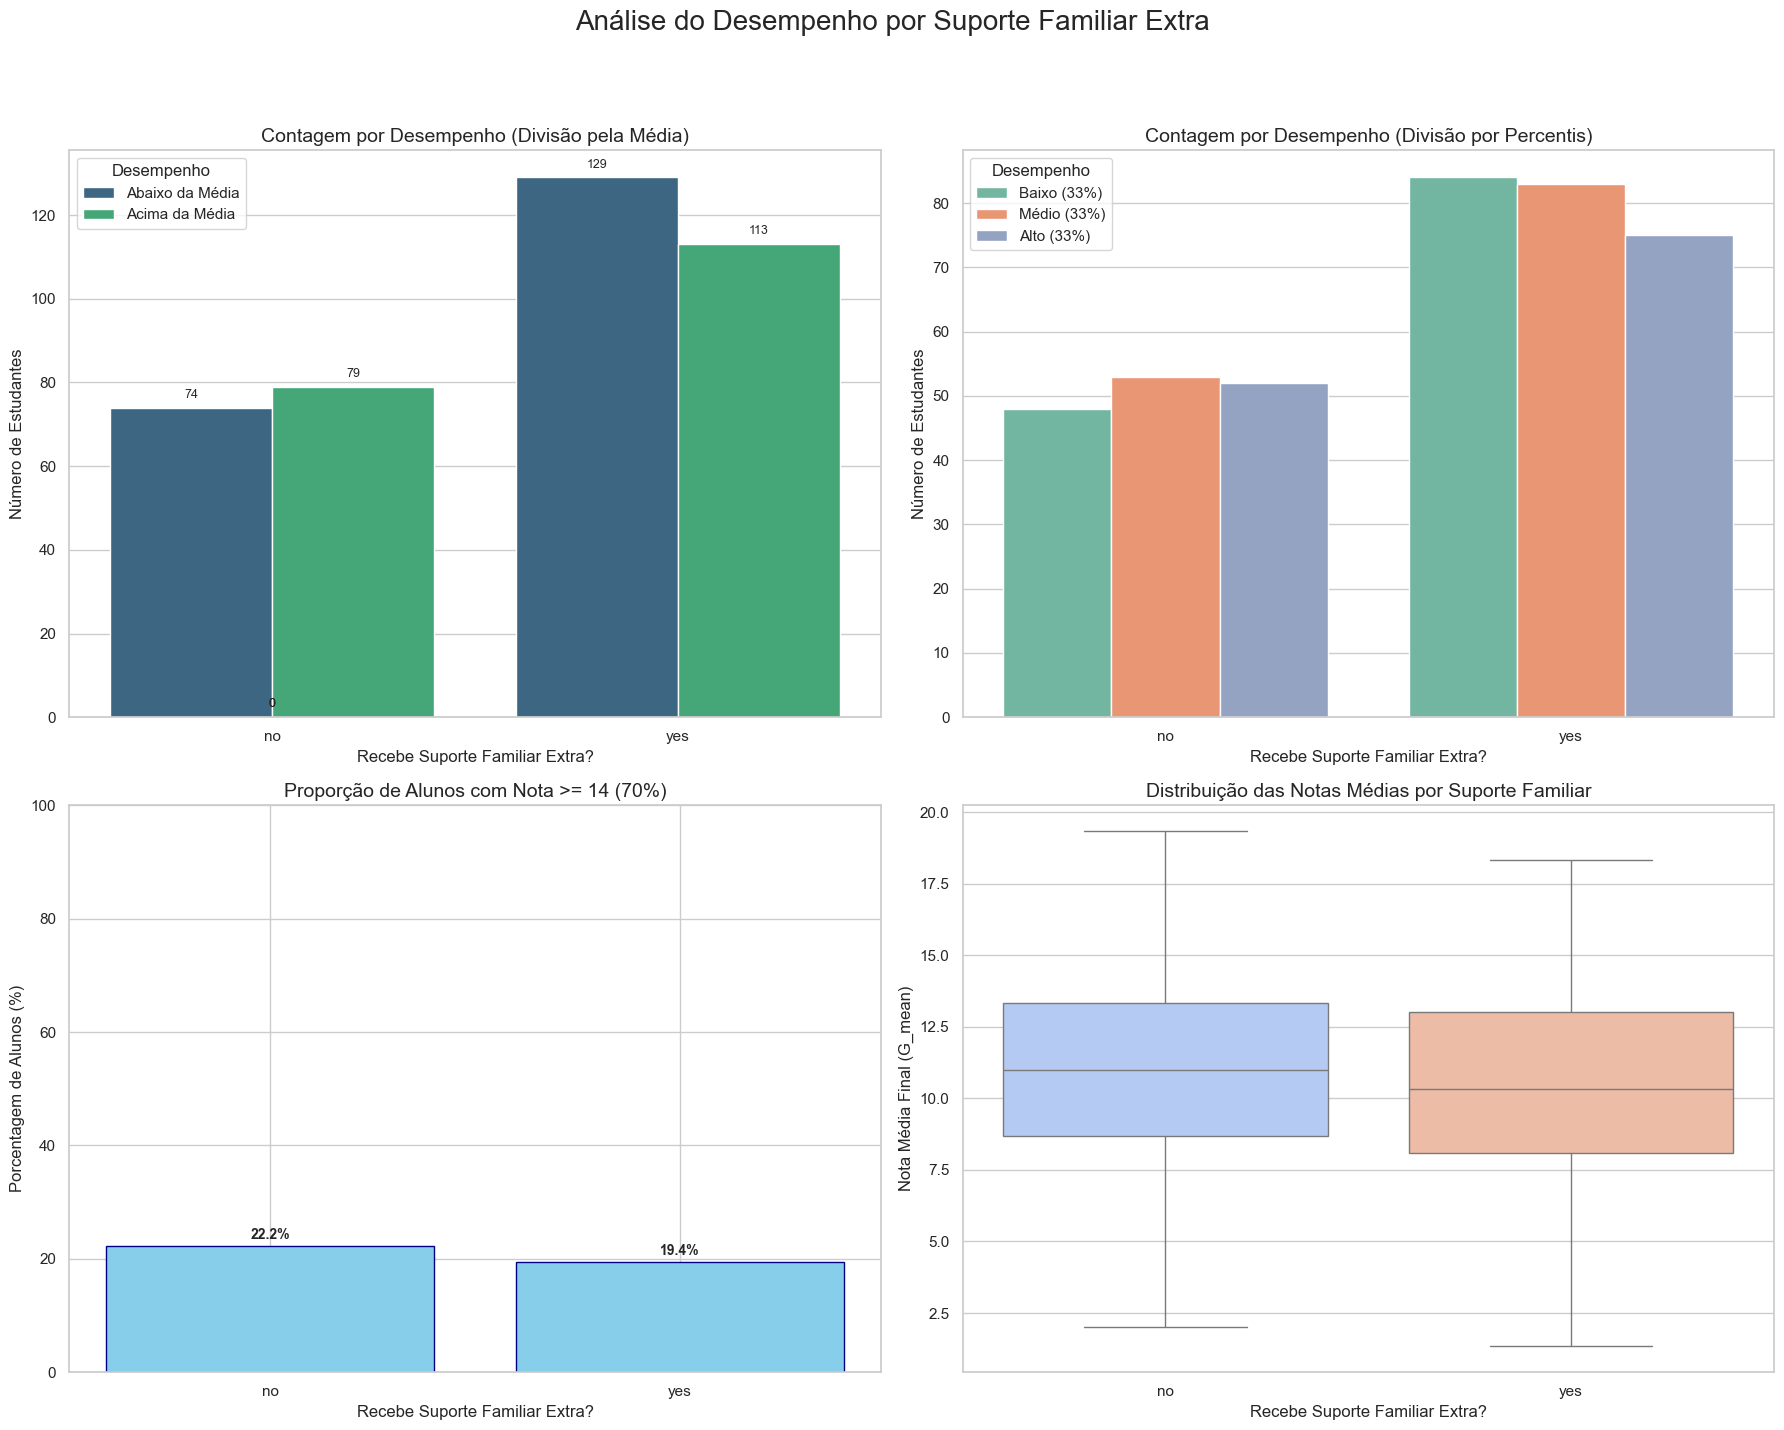

In [34]:
# Tabela descritiva
print("\n" + "="*60)
print("ANÁLISE 1: DISTRIBUIÇÃO POR SUPORTE FAMILIAR EXTRA")
print("="*60)

analise_famsup = df.groupby('famsup').agg({
    'G_mean': ['count', 'mean', 'std'],
    'acima_70_porcento': lambda x: (x == 'Sim').sum()
}).round(2)

analise_famsup.columns = ['Total_Alunos', 'Média_Notas', 'Desvio_Padrão', 'Qtd_Acima_70%']
analise_famsup['%_Acima_70%'] = (analise_famsup['Qtd_Acima_70%'] / analise_famsup['Total_Alunos'] * 100).round(1)
print(analise_famsup)

# Teste Qui-Quadrado para verificar a associação estatística
print("\n" + "="*60)
print("TESTE QUI-QUADRADO: SUPORTE FAMILIAR vs. DESEMPENHO")
print("="*60)

contingency_table = pd.crosstab(df['famsup'], df['desempenho_percentil'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Tabela de Contingência (Suporte Familiar vs Desempenho por Percentil):")
print(contingency_table)
print(f"\nEstatística Qui-Quadrado: {chi2:.4f}")
print(f"Valor p: {p_value:.4f}")
print(f"Graus de liberdade: {dof}")

if p_value < 0.05:
    print("\n✅ Há uma associação ESTATISTICAMENTE SIGNIFICATIVA entre receber suporte familiar e o desempenho do aluno (p < 0.05).")
else:
    print("\n❌ NÃO há associação significativa entre receber suporte familiar e o desempenho do aluno (p ≥ 0.05).")


# --------------------------------------------------------------------------
# 3. VISUALIZAÇÕES
# Criação do painel de gráficos 2x2
# --------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análise do Desempenho por Suporte Familiar Extra', fontsize=20, y=1.02)

# Gráfico 1: Contagem por Desempenho (Média Geral)
ax1 = axes[0, 0]
sns.countplot(data=df, x='famsup', hue='desempenho_media', ax=ax1, palette='viridis')
ax1.set_title('Contagem por Desempenho (Divisão pela Média)', fontsize=14)
ax1.set_xlabel('Recebe Suporte Familiar Extra?', fontsize=12)
ax1.set_ylabel('Número de Estudantes', fontsize=12)
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=9, xytext=(0, 5), textcoords='offset points')
ax1.legend(title='Desempenho')

# Gráfico 2: Contagem por Desempenho (Percentis)
ax2 = axes[0, 1]
sns.countplot(data=df, x='famsup', hue='desempenho_percentil', ax=ax2, palette='Set2')
ax2.set_title('Contagem por Desempenho (Divisão por Percentis)', fontsize=14)
ax2.set_xlabel('Recebe Suporte Familiar Extra?', fontsize=12)
ax2.set_ylabel('Número de Estudantes', fontsize=12)
ax2.legend(title='Desempenho')

# Gráfico 3: Proporção de Alunos com Nota Acima de 70%
ax3 = axes[1, 0]
prop_data = df.groupby('famsup')['acima_70_porcento'].apply(lambda x: (x == 'Sim').mean() * 100).fillna(0)
bars = ax3.bar(prop_data.index, prop_data.values, color='skyblue', edgecolor='navy')
ax3.set_title('Proporção de Alunos com Nota >= 14 (70%)', fontsize=14)
ax3.set_xlabel('Recebe Suporte Familiar Extra?', fontsize=12)
ax3.set_ylabel('Porcentagem de Alunos (%)', fontsize=12)
ax3.set_ylim(0, 100)
for bar in bars:
    height = bar.get_height()
    ax3.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, weight='bold')

# Gráfico 4: Boxplot da Distribuição das Notas Médias
ax4 = axes[1, 1]
sns.boxplot(data=df, x='famsup', y='G_mean', hue='famsup', ax=ax4, palette='coolwarm')
ax4.set_title('Distribuição das Notas Médias por Suporte Familiar', fontsize=14)
ax4.set_xlabel('Recebe Suporte Familiar Extra?', fontsize=12)
ax4.set_ylabel('Nota Média Final (G_mean)', fontsize=12)

# Ajusta o layout para evitar sobreposição e exibe os gráficos
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('analise_suporte_familiar.png', dpi=300, bbox_inches='tight') # Salva a imagem
plt.show() # Exibe os gráficos


ANÁLISE 1: DISTRIBUIÇÃO POR AULAS PARTICULARES PAGAS
      Total_Alunos  Média_Notas  Desvio_Padrão  Qtd_Acima_70%  %_Acima_70%
paid                                                                      
no             214        10.38           4.11             42         19.6
yes            181        11.04           3.12             39         21.5

TESTE QUI-QUADRADO: AULAS PAGAS vs. DESEMPENHO
Tabela de Contingência (Aulas Pagas vs Desempenho por Percentil):
desempenho_percentil  Baixo (33%)  Médio (33%)  Alto (33%)
paid                                                      
no                             82           64          68
yes                            50           72          59

Estatística Qui-Quadrado: 6.1519
Valor p: 0.0461
Graus de liberdade: 2

✅ Há uma associação ESTATISTICAMENTE SIGNIFICATIVA entre frequentar aulas pagas e o desempenho do aluno (p < 0.05).


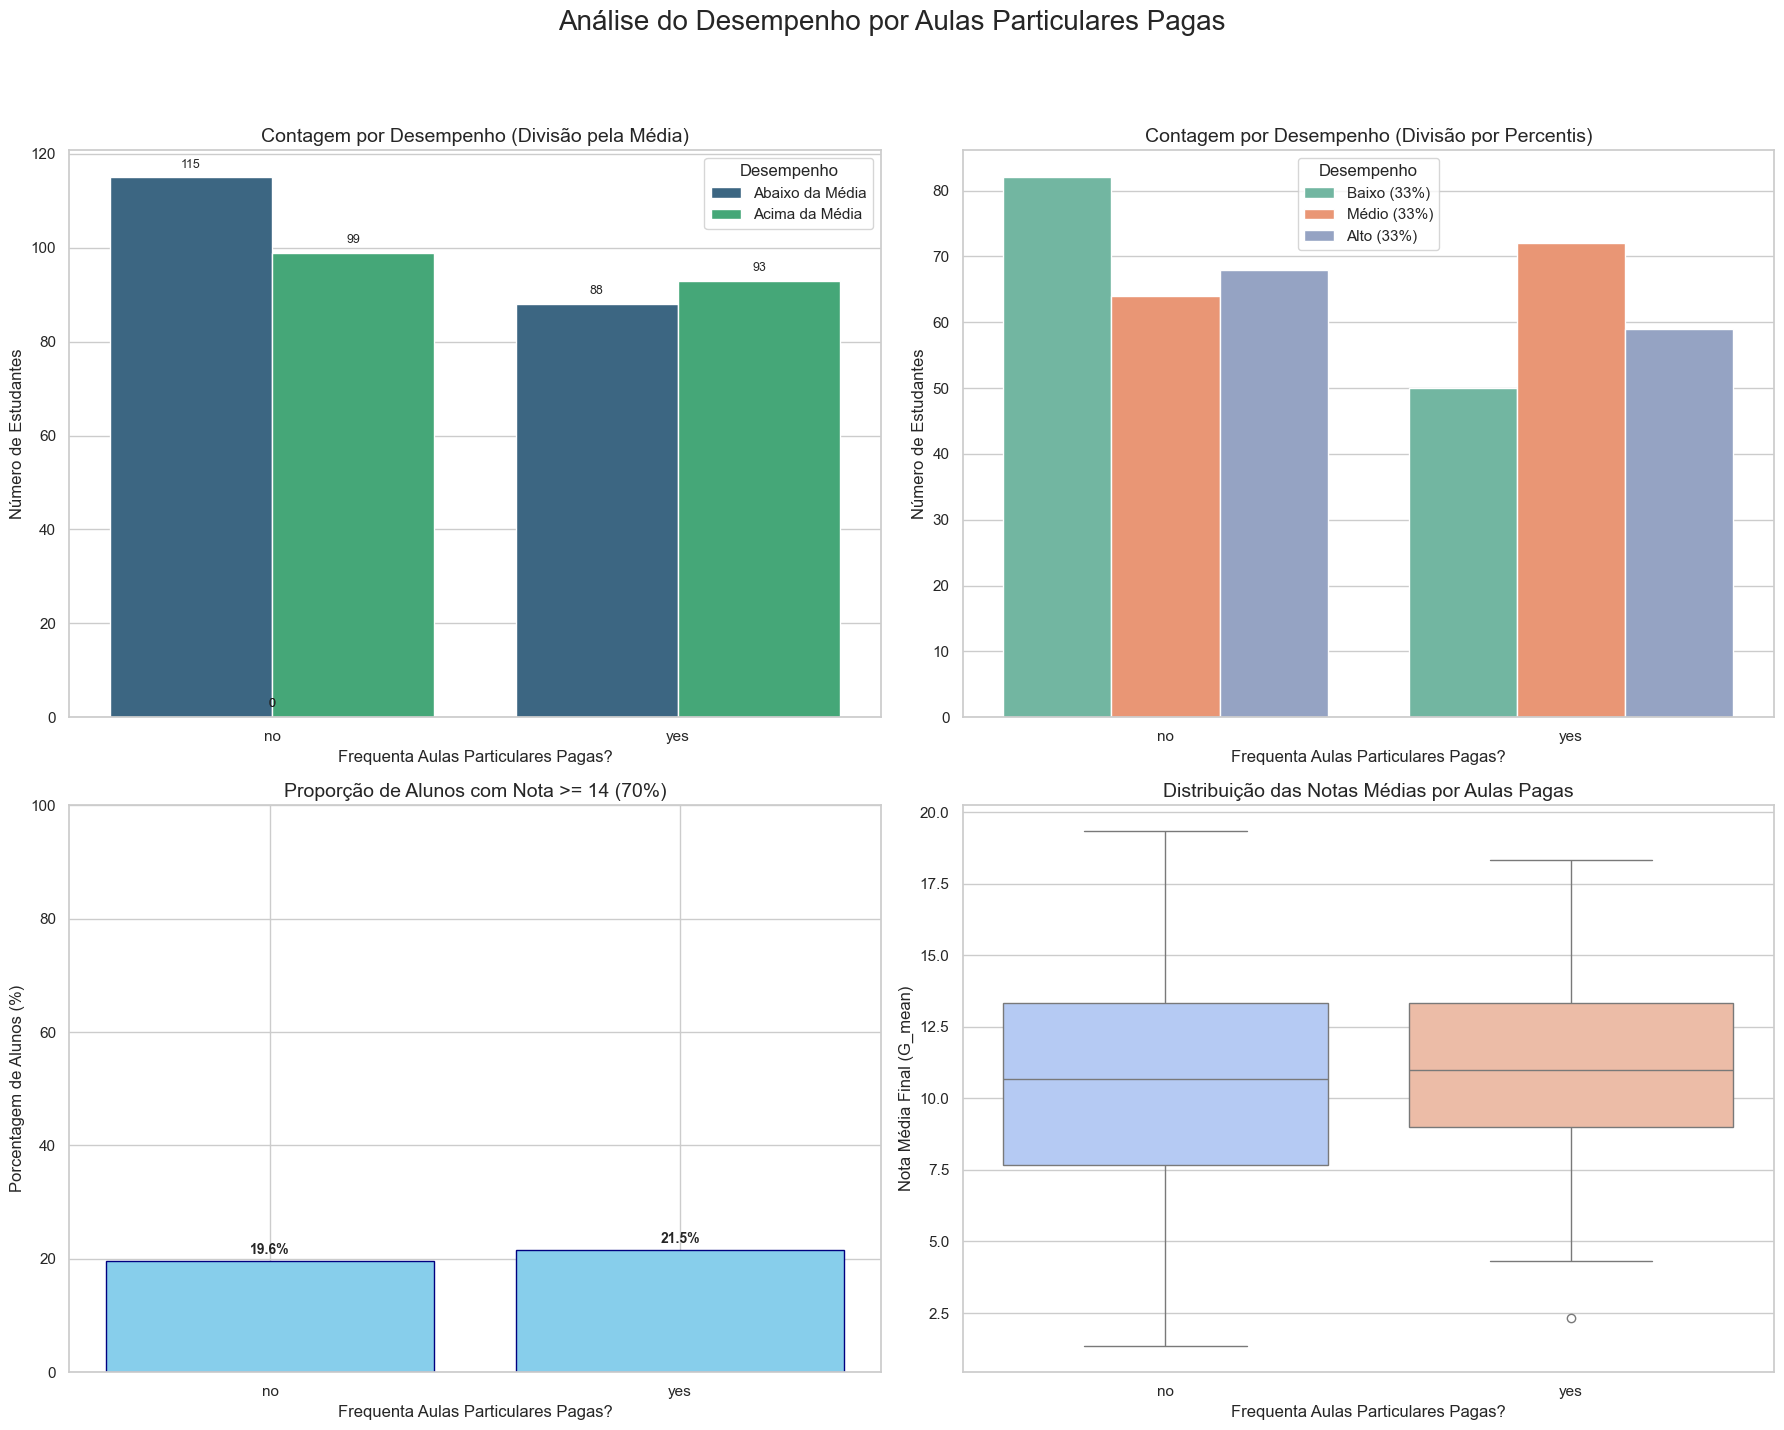

In [35]:
# Tabela descritiva
print("\n" + "="*60)
print("ANÁLISE 1: DISTRIBUIÇÃO POR AULAS PARTICULARES PAGAS")
print("="*60)

analise_aulas_pagas = df.groupby('paid').agg({
    'G_mean': ['count', 'mean', 'std'],
    'acima_70_porcento': lambda x: (x == 'Sim').sum()
}).round(2)

analise_aulas_pagas.columns = ['Total_Alunos', 'Média_Notas', 'Desvio_Padrão', 'Qtd_Acima_70%']
analise_aulas_pagas['%_Acima_70%'] = (analise_aulas_pagas['Qtd_Acima_70%'] / analise_aulas_pagas['Total_Alunos'] * 100).round(1)
print(analise_aulas_pagas)

# Teste Qui-Quadrado para verificar a associação estatística
print("\n" + "="*60)
print("TESTE QUI-QUADRADO: AULAS PAGAS vs. DESEMPENHO")
print("="*60)

contingency_table = pd.crosstab(df['paid'], df['desempenho_percentil'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Tabela de Contingência (Aulas Pagas vs Desempenho por Percentil):")
print(contingency_table)
print(f"\nEstatística Qui-Quadrado: {chi2:.4f}")
print(f"Valor p: {p_value:.4f}")
print(f"Graus de liberdade: {dof}")

if p_value < 0.05:
    print("\n✅ Há uma associação ESTATISTICAMENTE SIGNIFICATIVA entre frequentar aulas pagas e o desempenho do aluno (p < 0.05).")
else:
    print("\n❌ NÃO há associação significativa entre frequentar aulas pagas e o desempenho do aluno (p ≥ 0.05).")


# --------------------------------------------------------------------------
# 3. VISUALIZAÇÕES
# Criação do painel de gráficos 2x2
# --------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análise do Desempenho por Aulas Particulares Pagas', fontsize=20, y=1.02)

# Gráfico 1: Contagem por Desempenho (Média Geral)
ax1 = axes[0, 0]
sns.countplot(data=df, x='paid', hue='desempenho_media', ax=ax1, palette='viridis')
ax1.set_title('Contagem por Desempenho (Divisão pela Média)', fontsize=14)
ax1.set_xlabel('Frequenta Aulas Particulares Pagas?', fontsize=12)
ax1.set_ylabel('Número de Estudantes', fontsize=12)
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=9, xytext=(0, 5), textcoords='offset points')
ax1.legend(title='Desempenho')

# Gráfico 2: Contagem por Desempenho (Percentis)
ax2 = axes[0, 1]
sns.countplot(data=df, x='paid', hue='desempenho_percentil', ax=ax2, palette='Set2')
ax2.set_title('Contagem por Desempenho (Divisão por Percentis)', fontsize=14)
ax2.set_xlabel('Frequenta Aulas Particulares Pagas?', fontsize=12)
ax2.set_ylabel('Número de Estudantes', fontsize=12)
ax2.legend(title='Desempenho')

# Gráfico 3: Proporção de Alunos com Nota Acima de 70%
ax3 = axes[1, 0]
prop_data = df.groupby('paid')['acima_70_porcento'].apply(lambda x: (x == 'Sim').mean() * 100).fillna(0)
bars = ax3.bar(prop_data.index, prop_data.values, color='skyblue', edgecolor='navy')
ax3.set_title('Proporção de Alunos com Nota >= 14 (70%)', fontsize=14)
ax3.set_xlabel('Frequenta Aulas Particulares Pagas?', fontsize=12)
ax3.set_ylabel('Porcentagem de Alunos (%)', fontsize=12)
ax3.set_ylim(0, 100)
for bar in bars:
    height = bar.get_height()
    ax3.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, weight='bold')

# Gráfico 4: Boxplot da Distribuição das Notas Médias
ax4 = axes[1, 1]
sns.boxplot(data=df, x='paid', y='G_mean', hue='paid', ax=ax4, palette='coolwarm')
ax4.set_title('Distribuição das Notas Médias por Aulas Pagas', fontsize=14)
ax4.set_xlabel('Frequenta Aulas Particulares Pagas?', fontsize=12)
ax4.set_ylabel('Nota Média Final (G_mean)', fontsize=12)

# Ajusta o layout para evitar sobreposição e exibe os gráficos
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('analise_aulas_pagas.png', dpi=300, bbox_inches='tight') # Salva a imagem
plt.show() # Exibe os gráficos


ANÁLISE 1: DISTRIBUIÇÃO POR ATIVIDADES EXTRACURRICULARES
            Total_Alunos  Média_Notas  Desvio_Padrão  Qtd_Acima_70%  \
activities                                                            
no                   194        10.53           3.72             36   
yes                  201        10.83           3.67             45   

            %_Acima_70%  
activities               
no                 18.6  
yes                22.4  

TESTE QUI-QUADRADO: ATIVIDADES EXTRACURRICULARES vs. DESEMPENHO
Tabela de Contingência (Atividades Extracurriculares vs Desempenho por Percentil):
desempenho_percentil  Baixo (33%)  Médio (33%)  Alto (33%)
activities                                                
no                             68           68          58
yes                            64           68          69

Estatística Qui-Quadrado: 0.9502
Valor p: 0.6218
Graus de liberdade: 2

❌ NÃO há associação significativa entre participar de atividades e o desempenho do aluno (p ≥ 0.

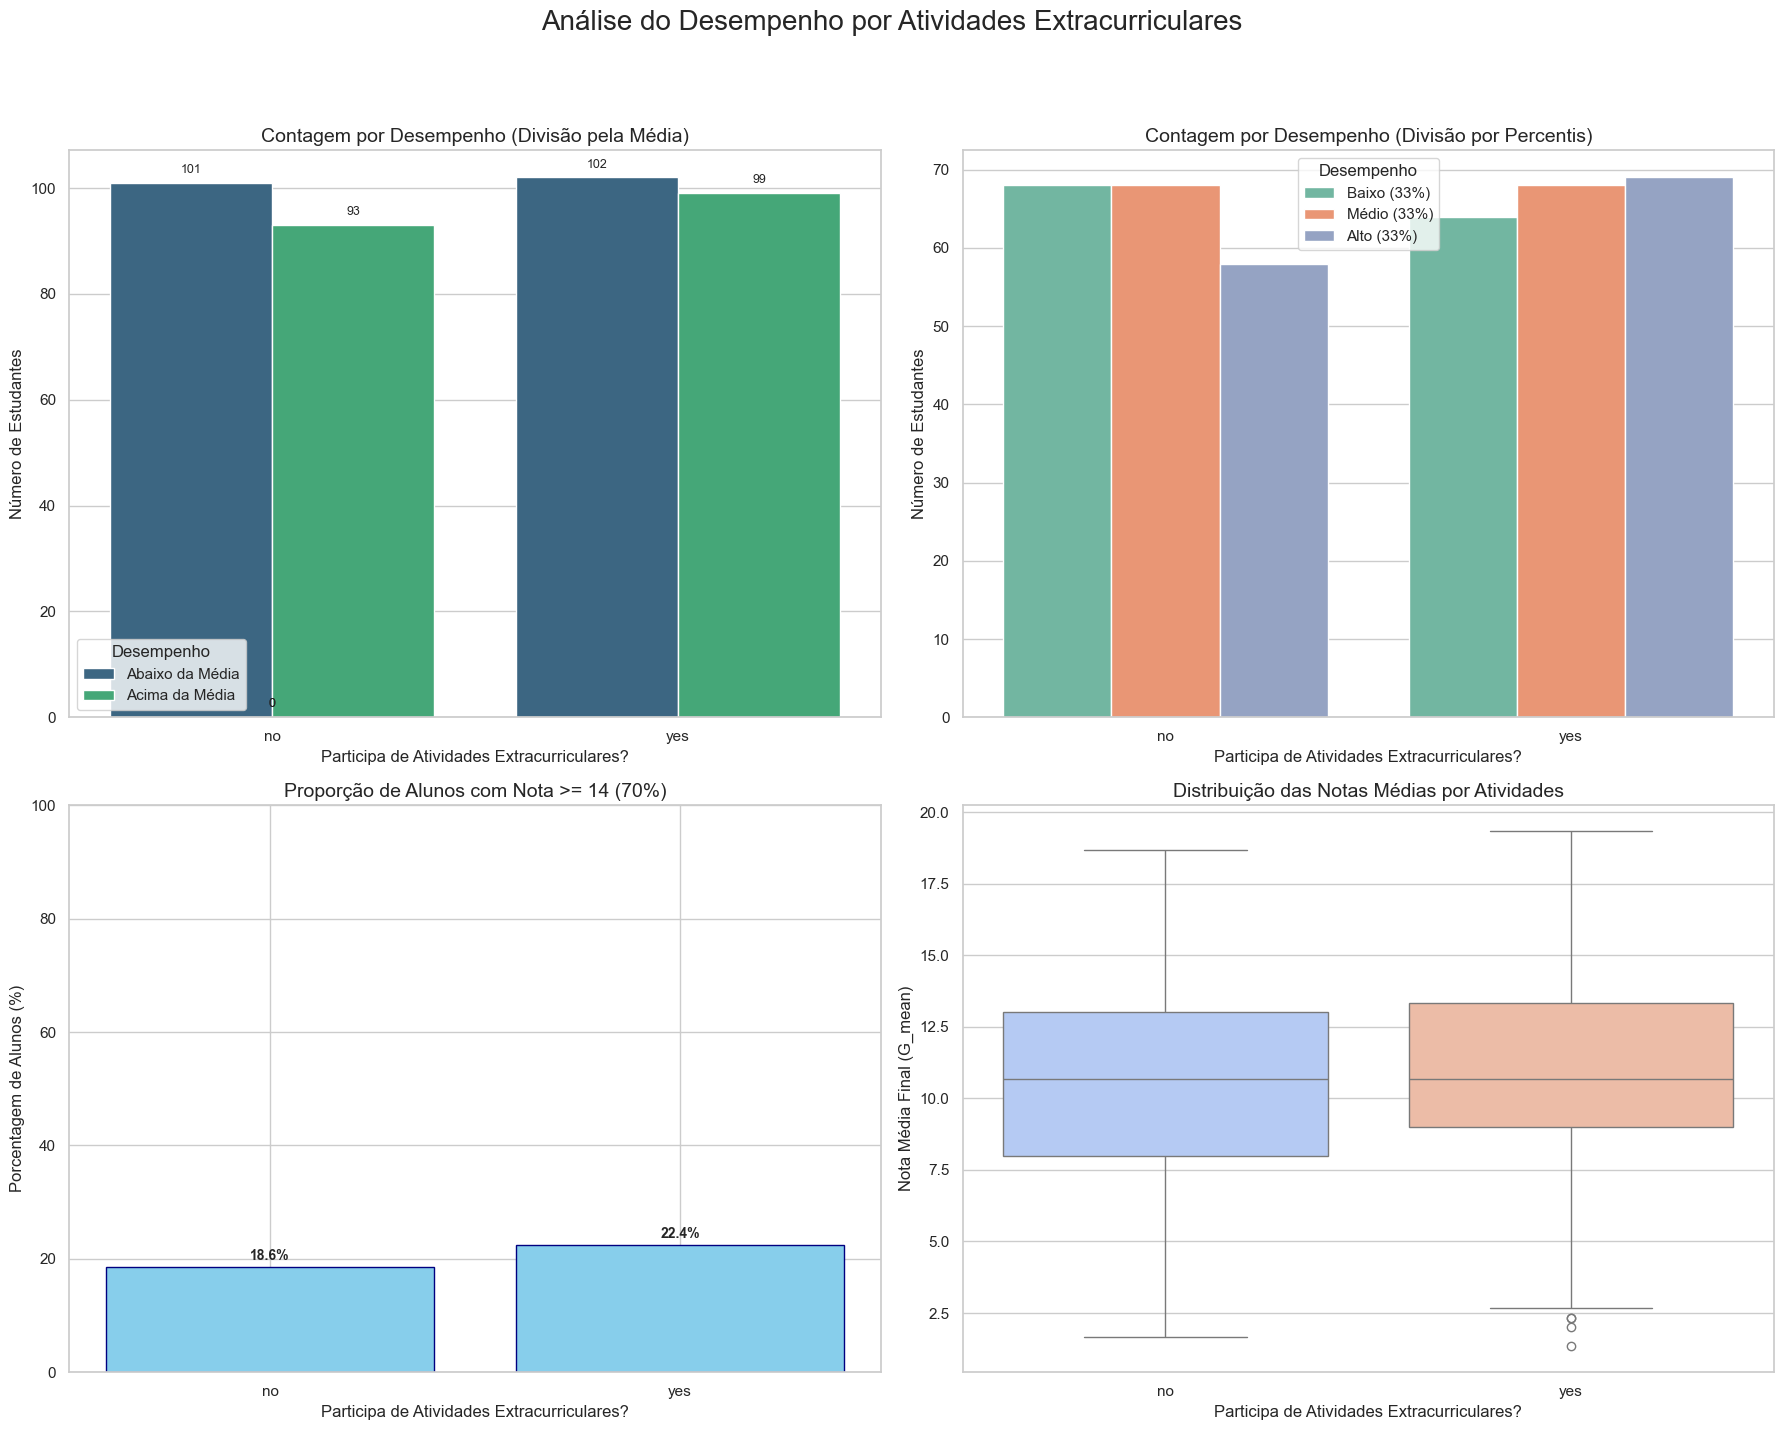

In [36]:
# Tabela descritiva
print("\n" + "="*60)
print("ANÁLISE 1: DISTRIBUIÇÃO POR ATIVIDADES EXTRACURRICULARES")
print("="*60)

analise_atividades = df.groupby('activities').agg({
    'G_mean': ['count', 'mean', 'std'],
    'acima_70_porcento': lambda x: (x == 'Sim').sum()
}).round(2)

analise_atividades.columns = ['Total_Alunos', 'Média_Notas', 'Desvio_Padrão', 'Qtd_Acima_70%']
analise_atividades['%_Acima_70%'] = (analise_atividades['Qtd_Acima_70%'] / analise_atividades['Total_Alunos'] * 100).round(1)
print(analise_atividades)

# Teste Qui-Quadrado para verificar a associação estatística
print("\n" + "="*60)
print("TESTE QUI-QUADRADO: ATIVIDADES EXTRACURRICULARES vs. DESEMPENHO")
print("="*60)

contingency_table = pd.crosstab(df['activities'], df['desempenho_percentil'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Tabela de Contingência (Atividades Extracurriculares vs Desempenho por Percentil):")
print(contingency_table)
print(f"\nEstatística Qui-Quadrado: {chi2:.4f}")
print(f"Valor p: {p_value:.4f}")
print(f"Graus de liberdade: {dof}")

if p_value < 0.05:
    print("\n✅ Há uma associação ESTATISTICAMENTE SIGNIFICATIVA entre participar de atividades e o desempenho do aluno (p < 0.05).")
else:
    print("\n❌ NÃO há associação significativa entre participar de atividades e o desempenho do aluno (p ≥ 0.05).")


# --------------------------------------------------------------------------
# 3. VISUALIZAÇÕES
# Criação do painel de gráficos 2x2
# --------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análise do Desempenho por Atividades Extracurriculares', fontsize=20, y=1.02)

# Gráfico 1: Contagem por Desempenho (Média Geral)
ax1 = axes[0, 0]
sns.countplot(data=df, x='activities', hue='desempenho_media', ax=ax1, palette='viridis')
ax1.set_title('Contagem por Desempenho (Divisão pela Média)', fontsize=14)
ax1.set_xlabel('Participa de Atividades Extracurriculares?', fontsize=12)
ax1.set_ylabel('Número de Estudantes', fontsize=12)
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=9, xytext=(0, 5), textcoords='offset points')
ax1.legend(title='Desempenho')

# Gráfico 2: Contagem por Desempenho (Percentis)
ax2 = axes[0, 1]
sns.countplot(data=df, x='activities', hue='desempenho_percentil', ax=ax2, palette='Set2')
ax2.set_title('Contagem por Desempenho (Divisão por Percentis)', fontsize=14)
ax2.set_xlabel('Participa de Atividades Extracurriculares?', fontsize=12)
ax2.set_ylabel('Número de Estudantes', fontsize=12)
ax2.legend(title='Desempenho')

# Gráfico 3: Proporção de Alunos com Nota Acima de 70%
ax3 = axes[1, 0]
prop_data = df.groupby('activities')['acima_70_porcento'].apply(lambda x: (x == 'Sim').mean() * 100).fillna(0)
bars = ax3.bar(prop_data.index, prop_data.values, color='skyblue', edgecolor='navy')
ax3.set_title('Proporção de Alunos com Nota >= 14 (70%)', fontsize=14)
ax3.set_xlabel('Participa de Atividades Extracurriculares?', fontsize=12)
ax3.set_ylabel('Porcentagem de Alunos (%)', fontsize=12)
ax3.set_ylim(0, 100)
for bar in bars:
    height = bar.get_height()
    ax3.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, weight='bold')

# Gráfico 4: Boxplot da Distribuição das Notas Médias
ax4 = axes[1, 1]
sns.boxplot(data=df, x='activities', y='G_mean', hue='activities', ax=ax4, palette='coolwarm')
ax4.set_title('Distribuição das Notas Médias por Atividades', fontsize=14)
ax4.set_xlabel('Participa de Atividades Extracurriculares?', fontsize=12)
ax4.set_ylabel('Nota Média Final (G_mean)', fontsize=12)

# Ajusta o layout para evitar sobreposição e exibe os gráficos
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('analise_atividades_extracurriculares.png', dpi=300, bbox_inches='tight') # Salva a imagem
plt.show() # Exibe os gráficos


ANÁLISE 1: DISTRIBUIÇÃO POR ACESSO À INTERNET
          Total_Alunos  Média_Notas  Desvio_Padrão  Qtd_Acima_70%  %_Acima_70%
internet                                                                      
no                  66         9.83           3.56              7         10.6
yes                329        10.85           3.71             74         22.5

TESTE QUI-QUADRADO: ACESSO À INTERNET vs. DESEMPENHO
Tabela de Contingência (Acesso à Internet vs Desempenho por Percentil):
desempenho_percentil  Baixo (33%)  Médio (33%)  Alto (33%)
internet                                                  
no                             27           23          16
yes                           105          113         111

Estatística Qui-Quadrado: 2.8766
Valor p: 0.2373
Graus de liberdade: 2

❌ NÃO há associação significativa entre ter acesso à internet e o desempenho do aluno (p ≥ 0.05).


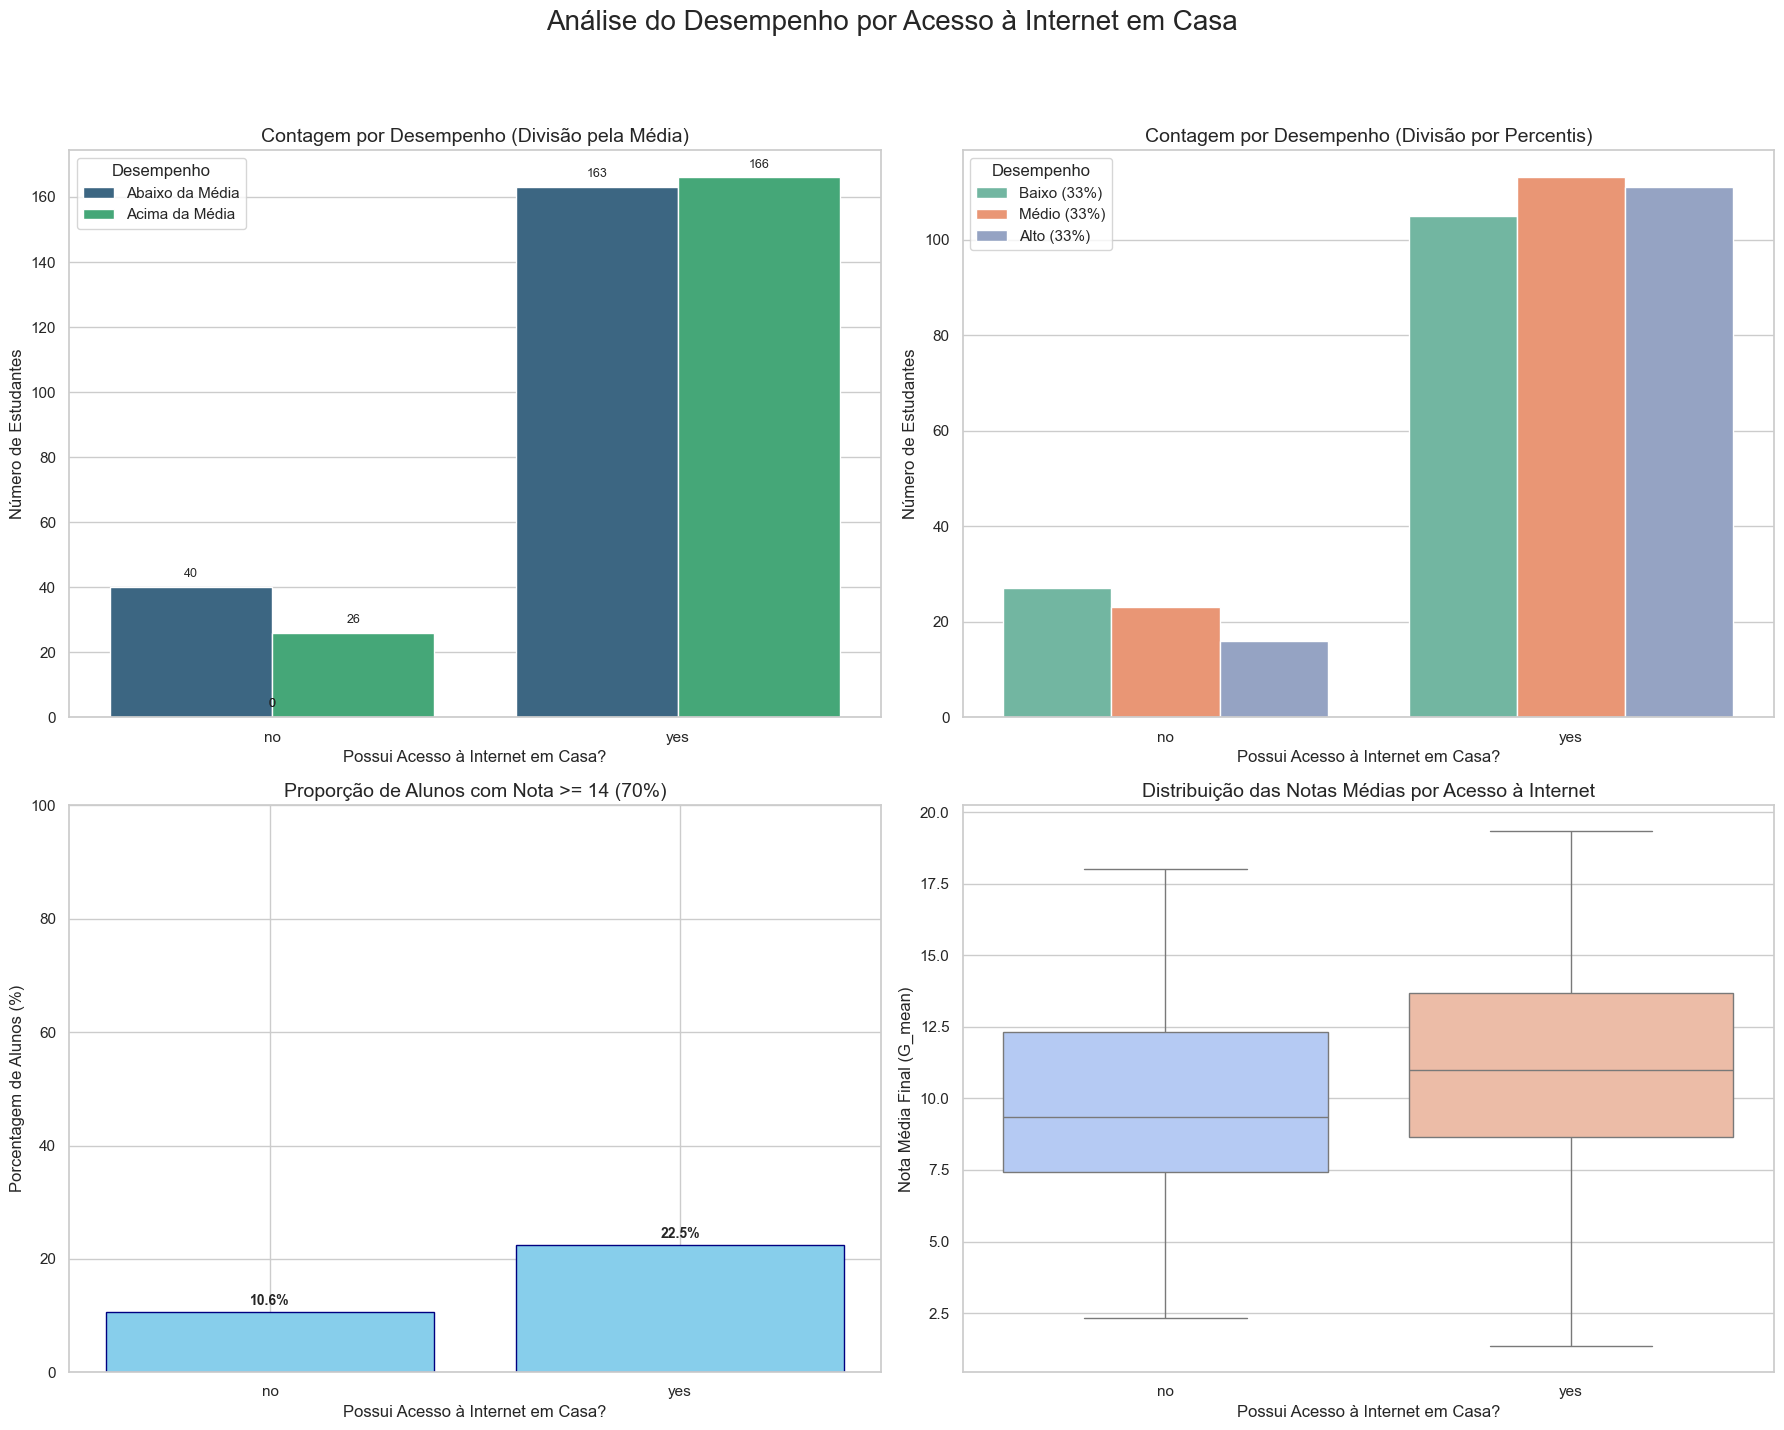

In [37]:
# Tabela descritiva
print("\n" + "="*60)
print("ANÁLISE 1: DISTRIBUIÇÃO POR ACESSO À INTERNET")
print("="*60)

analise_internet = df.groupby('internet').agg({
    'G_mean': ['count', 'mean', 'std'],
    'acima_70_porcento': lambda x: (x == 'Sim').sum()
}).round(2)

analise_internet.columns = ['Total_Alunos', 'Média_Notas', 'Desvio_Padrão', 'Qtd_Acima_70%']
analise_internet['%_Acima_70%'] = (analise_internet['Qtd_Acima_70%'] / analise_internet['Total_Alunos'] * 100).round(1)
print(analise_internet)

# Teste Qui-Quadrado para verificar a associação estatística
print("\n" + "="*60)
print("TESTE QUI-QUADRADO: ACESSO À INTERNET vs. DESEMPENHO")
print("="*60)

contingency_table = pd.crosstab(df['internet'], df['desempenho_percentil'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Tabela de Contingência (Acesso à Internet vs Desempenho por Percentil):")
print(contingency_table)
print(f"\nEstatística Qui-Quadrado: {chi2:.4f}")
print(f"Valor p: {p_value:.4f}")
print(f"Graus de liberdade: {dof}")

if p_value < 0.05:
    print("\n✅ Há uma associação ESTATISTICAMENTE SIGNIFICATIVA entre ter acesso à internet e o desempenho do aluno (p < 0.05).")
else:
    print("\n❌ NÃO há associação significativa entre ter acesso à internet e o desempenho do aluno (p ≥ 0.05).")


# --------------------------------------------------------------------------
# 3. VISUALIZAÇÕES
# Criação do painel de gráficos 2x2
# --------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análise do Desempenho por Acesso à Internet em Casa', fontsize=20, y=1.02)

# Gráfico 1: Contagem por Desempenho (Média Geral)
ax1 = axes[0, 0]
sns.countplot(data=df, x='internet', hue='desempenho_media', ax=ax1, palette='viridis')
ax1.set_title('Contagem por Desempenho (Divisão pela Média)', fontsize=14)
ax1.set_xlabel('Possui Acesso à Internet em Casa?', fontsize=12)
ax1.set_ylabel('Número de Estudantes', fontsize=12)
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=9, xytext=(0, 5), textcoords='offset points')
ax1.legend(title='Desempenho')

# Gráfico 2: Contagem por Desempenho (Percentis)
ax2 = axes[0, 1]
sns.countplot(data=df, x='internet', hue='desempenho_percentil', ax=ax2, palette='Set2')
ax2.set_title('Contagem por Desempenho (Divisão por Percentis)', fontsize=14)
ax2.set_xlabel('Possui Acesso à Internet em Casa?', fontsize=12)
ax2.set_ylabel('Número de Estudantes', fontsize=12)
ax2.legend(title='Desempenho')

# Gráfico 3: Proporção de Alunos com Nota Acima de 70%
ax3 = axes[1, 0]
prop_data = df.groupby('internet')['acima_70_porcento'].apply(lambda x: (x == 'Sim').mean() * 100).fillna(0)
bars = ax3.bar(prop_data.index, prop_data.values, color='skyblue', edgecolor='navy')
ax3.set_title('Proporção de Alunos com Nota >= 14 (70%)', fontsize=14)
ax3.set_xlabel('Possui Acesso à Internet em Casa?', fontsize=12)
ax3.set_ylabel('Porcentagem de Alunos (%)', fontsize=12)
ax3.set_ylim(0, 100)
for bar in bars:
    height = bar.get_height()
    ax3.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, weight='bold')

# Gráfico 4: Boxplot da Distribuição das Notas Médias
ax4 = axes[1, 1]
sns.boxplot(data=df, x='internet', y='G_mean', hue='internet', ax=ax4, palette='coolwarm')
ax4.set_title('Distribuição das Notas Médias por Acesso à Internet', fontsize=14)
ax4.set_xlabel('Possui Acesso à Internet em Casa?', fontsize=12)
ax4.set_ylabel('Nota Média Final (G_mean)', fontsize=12)

# Ajusta o layout para evitar sobreposição e exibe os gráficos
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('analise_acesso_internet.png', dpi=300, bbox_inches='tight') # Salva a imagem
plt.show() # Exibe os gráficos


ANÁLISE 1: DISTRIBUIÇÃO POR ESTADO DE SAÚDE
        Total  Média_Notas  Desvio_Padrão  Acima_70%  %_Acima_70%
health                                                           
1          47        11.87           3.67         16         34.0
2          45        10.87           3.95         12         26.7
3          91        10.30           3.41         13         14.3
4          66        10.40           3.87         12         18.2
5         146        10.60           3.68         28         19.2

TESTE QUI-QUADRADO
Tabela de Contingência (Saúde vs Desempenho por Percentil):
desempenho_percentil  Baixo (33%)  Médio (33%)  Alto (33%)
health                                                    
1                              12           14          21
2                              18           11          16
3                              33           36          22
4                              22           23          21
5                              47           52          47


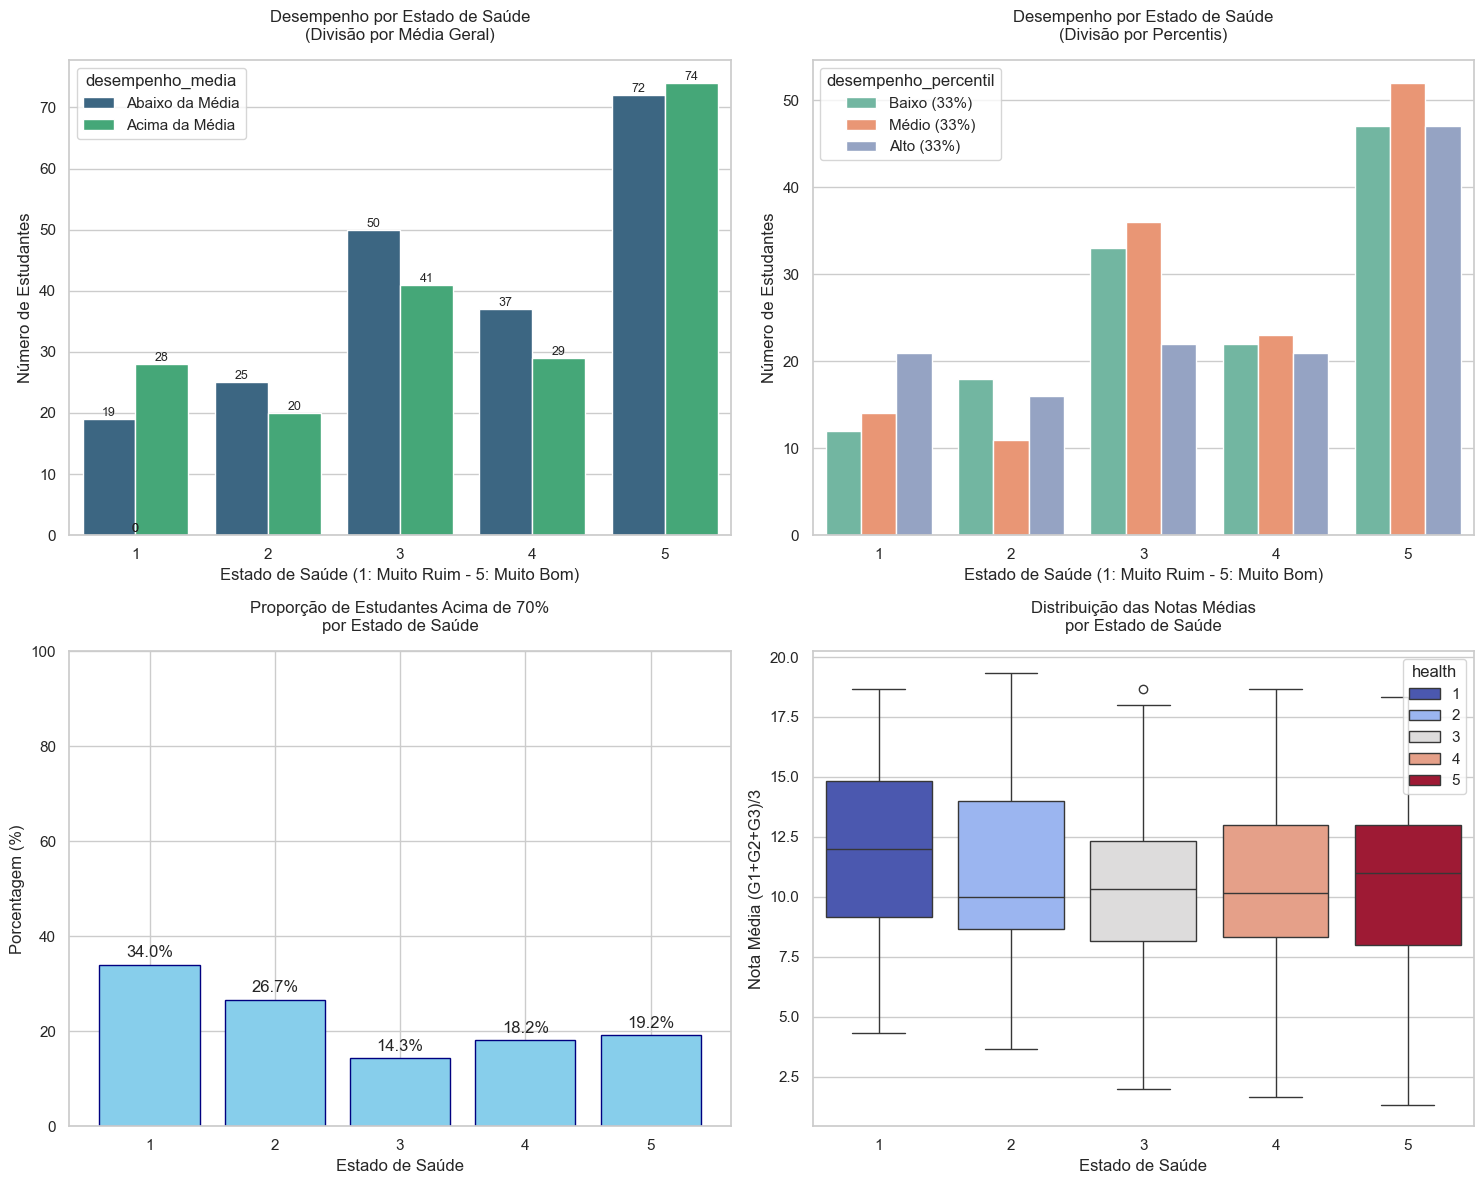


RESUMO DA ANÁLISE
• Total de estudantes analisados: 395
• Nota média geral: 10.68 (DP: 3.70)
• Estudantes acima de 70% da nota: 81 (20.5%)
• Associação estado de saúde × desempenho: Não significativa (p = 0.3991)


In [25]:


# Método 1: Categorização por média (seu método original)
overall_mean = df['G_mean'].mean()
df['desempenho_media'] = np.where(df['G_mean'] < overall_mean, 'Abaixo da Média', 'Acima da Média')

# Método 2: Categorização por percentis (mais equilibrada)
df['desempenho_percentil'] = pd.qcut(df['G_mean'], 
                                   q=3, 
                                   labels=['Baixo (33%)', 'Médio (33%)', 'Alto (33%)'])

# Método 3: Categorização por critério específico (ex: 70% da nota máxima = 14)
nota_limite = 14  # 70% de 20
df['acima_70_porcento'] = np.where(df['G_mean'] >= nota_limite, 'Sim', 'Não')

# Análise 1: Distribuição por estado de saúde
print("\n" + "="*50)
print("ANÁLISE 1: DISTRIBUIÇÃO POR ESTADO DE SAÚDE")
print("="*50)

analise_saude = df.groupby('health').agg({
    'G_mean': ['count', 'mean', 'std'],
    'acima_70_porcento': lambda x: (x == 'Sim').sum()
}).round(2)

analise_saude.columns = ['Total', 'Média_Notas', 'Desvio_Padrão', 'Acima_70%']
analise_saude['%_Acima_70%'] = (analise_saude['Acima_70%'] / analise_saude['Total'] * 100).round(1)
print(analise_saude)

# Teste Qui-Quadrado
print("\n" + "="*50)
print("TESTE QUI-QUADRADO")
print("="*50)

# Teste 1: Desempenho por percentil vs Saúde
contingency_table = pd.crosstab(df['health'], df['desempenho_percentil'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Tabela de Contingência (Saúde vs Desempenho por Percentil):")
print(contingency_table)
print(f"\nEstatística Qui-Quadrado: {chi2:.4f}")
print(f"Valor p: {p_value:.4f}")
print(f"Graus de liberdade: {dof}")

if p_value < 0.05:
    print("✅ Há associação SIGNIFICATIVA entre estado de saúde e desempenho (p < 0.05)")
else:
    print("❌ NÃO há associação significativa entre estado de saúde e desempenho (p ≥ 0.05)")

# Teste 2: Acima de 70% vs Saúde
contingency_table2 = pd.crosstab(df['health'], df['acima_70_porcento'])
chi2_2, p_value_2, dof_2, expected_2 = chi2_contingency(contingency_table2)

print(f"\nTeste para 'Acima de 70%' vs Saúde:")
print(f"Valor p: {p_value_2:.4f}")
print("✅ Significativo" if p_value_2 < 0.05 else "❌ Não significativo")

# Visualizações
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Método original (melhorado)
ax1 = axes[0, 0]
sns.countplot(data=df, x='health', hue='desempenho_media', ax=ax1, palette='viridis')
ax1.set_title('Desempenho por Estado de Saúde\n(Divisão por Média Geral)', fontsize=12, pad=15)
ax1.set_xlabel('Estado de Saúde (1: Muito Ruim - 5: Muito Bom)')
ax1.set_ylabel('Número de Estudantes')

# Adicionar valores nas barras
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=9)

# Gráfico 2: Por percentis
ax2 = axes[0, 1]
sns.countplot(data=df, x='health', hue='desempenho_percentil', ax=ax2, palette='Set2')
ax2.set_title('Desempenho por Estado de Saúde\n(Divisão por Percentis)', fontsize=12, pad=15)
ax2.set_xlabel('Estado de Saúde (1: Muito Ruim - 5: Muito Bom)')
ax2.set_ylabel('Número de Estudantes')

# Gráfico 3: Proporção acima de 70%
ax3 = axes[1, 0]
prop_data = df.groupby('health')['acima_70_porcento'].apply(lambda x: (x == 'Sim').mean() * 100)
bars = ax3.bar(prop_data.index, prop_data.values, color='skyblue', edgecolor='navy')
ax3.set_title('Proporção de Estudantes Acima de 70%\npor Estado de Saúde', fontsize=12, pad=15)
ax3.set_xlabel('Estado de Saúde')
ax3.set_ylabel('Porcentagem (%)')
ax3.set_ylim(0, 100)

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    ax3.annotate(f'{height:.1f}%', 
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom')

# Gráfico 4: Box plot das notas por saúde
ax4 = axes[1, 1]
sns.boxplot(data=df, x='health', y='G_mean',hue='health', ax=ax4, palette='coolwarm')
ax4.set_title('Distribuição das Notas Médias\npor Estado de Saúde', fontsize=12, pad=15)
ax4.set_xlabel('Estado de Saúde')
ax4.set_ylabel('Nota Média (G1+G2+G3)/3')

plt.tight_layout()
plt.show()

# Resumo final
print("\n" + "="*50)
print("RESUMO DA ANÁLISE")
print("="*50)
print(f"• Total de estudantes analisados: {len(df)}")
print(f"• Nota média geral: {df['G_mean'].mean():.2f} (DP: {df['G_mean'].std():.2f})")
print(f"• Estudantes acima de 70% da nota: {(df['acima_70_porcento'] == 'Sim').sum()} ({(df['acima_70_porcento'] == 'Sim').mean()*100:.1f}%)")
print(f"• Associação estado de saúde × desempenho: {'Significativa' if p_value < 0.05 else 'Não significativa'} (p = {p_value:.4f})")


ANÁLISE 1: DISTRIBUIÇÃO POR TEMPO LIVRE APÓS A ESCOLA
          Total_Alunos  Média_Notas  Desvio_Padrão  Qtd_Acima_70%  %_Acima_70%
freetime                                                                      
1                   19        10.14           3.96              3         15.8
2                   64        11.78           3.43             18         28.1
3                  157        10.14           3.66             25         15.9
4                  115        10.61           3.60             23         20.0
5                   40        11.48           4.07             12         30.0

TESTE QUI-QUADRADO: TEMPO LIVRE vs. DESEMPENHO
Tabela de Contingência (Tempo Livre vs Desempenho por Percentil):
desempenho_percentil  Baixo (33%)  Médio (33%)  Alto (33%)
freetime                                                  
1                               9            6           4
2                              14           24          26
3                              59         

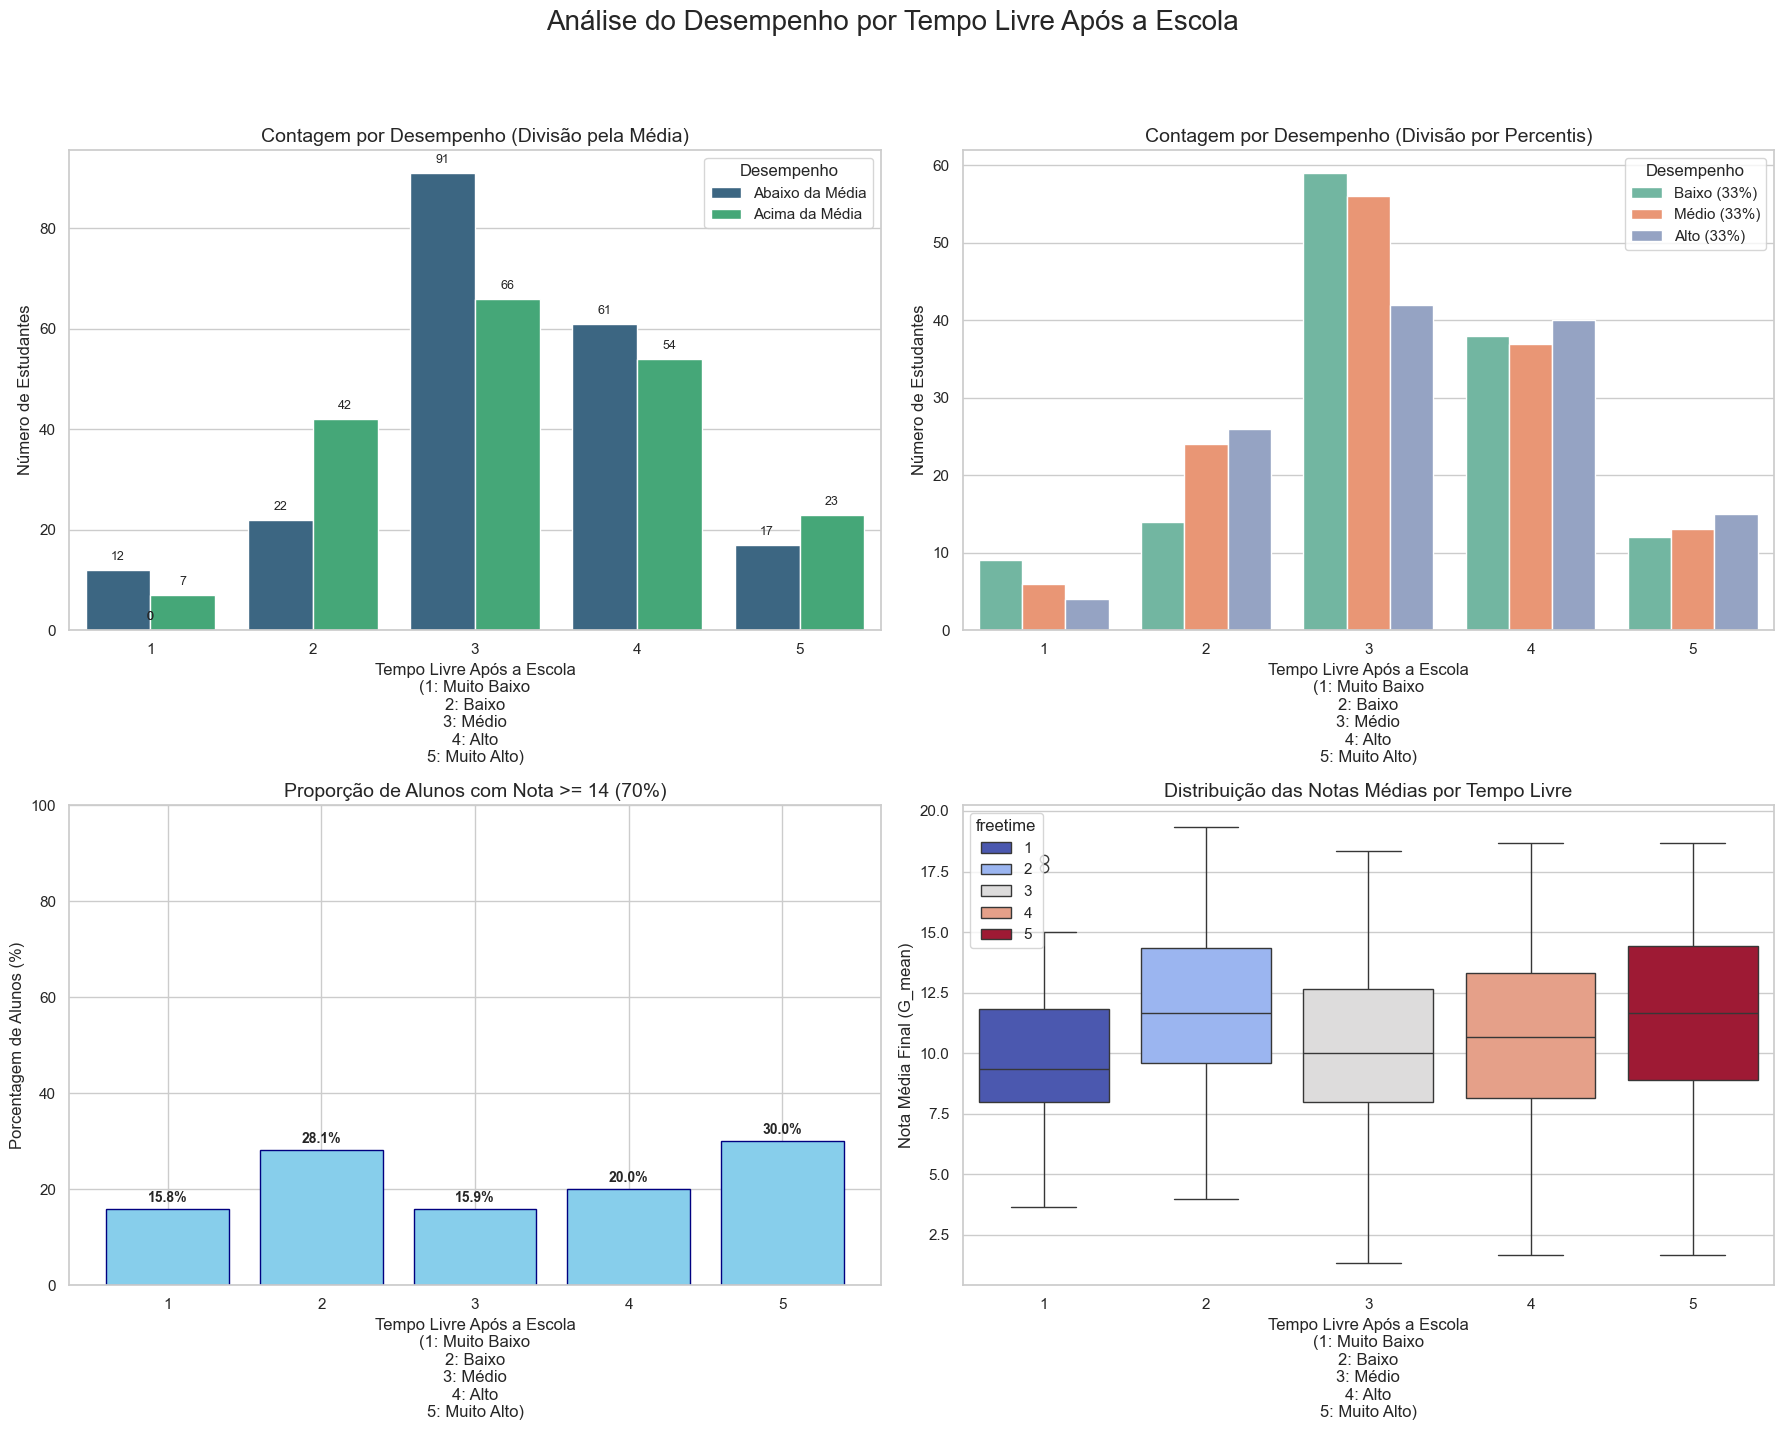

In [5]:
# Tabela descritiva
print("\n" + "="*60)
print("ANÁLISE 1: DISTRIBUIÇÃO POR TEMPO LIVRE APÓS A ESCOLA")
print("="*60)

analise_tempo_livre = df.groupby('freetime').agg({
    'G_mean': ['count', 'mean', 'std'],
    'acima_70_porcento': lambda x: (x == 'Sim').sum()
}).round(2)

analise_tempo_livre.columns = ['Total_Alunos', 'Média_Notas', 'Desvio_Padrão', 'Qtd_Acima_70%']
analise_tempo_livre['%_Acima_70%'] = (analise_tempo_livre['Qtd_Acima_70%'] / analise_tempo_livre['Total_Alunos'] * 100).round(1)
print(analise_tempo_livre)

# Teste Qui-Quadrado para verificar a associação estatística
print("\n" + "="*60)
print("TESTE QUI-QUADRADO: TEMPO LIVRE vs. DESEMPENHO")
print("="*60)

contingency_table = pd.crosstab(df['freetime'], df['desempenho_percentil'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Tabela de Contingência (Tempo Livre vs Desempenho por Percentil):")
print(contingency_table)
print(f"\nEstatística Qui-Quadrado: {chi2:.4f}")
print(f"Valor p: {p_value:.4f}")
print(f"Graus de liberdade: {dof}")

if p_value < 0.05:
    print("\n✅ Há uma associação ESTATISTICAMENTE SIGNIFICATIVA entre o tempo livre e o desempenho do aluno (p < 0.05).")
else:
    print("\n❌ NÃO há associação significativa entre o tempo livre e o desempenho do aluno (p ≥ 0.05).")


# --------------------------------------------------------------------------
# 3. VISUALIZAÇÕES
# Criação do painel de gráficos 2x2
# --------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análise do Desempenho por Tempo Livre Após a Escola', fontsize=20, y=1.02)

# Rótulos do eixo X
freetime_labels = '1: Muito Baixo\n2: Baixo\n3: Médio\n4: Alto\n5: Muito Alto'

# Gráfico 1: Contagem por Desempenho (Média Geral)
ax1 = axes[0, 0]
sns.countplot(data=df, x='freetime', hue='desempenho_media', ax=ax1, palette='viridis')
ax1.set_title('Contagem por Desempenho (Divisão pela Média)', fontsize=14)
ax1.set_xlabel(f'Tempo Livre Após a Escola\n({freetime_labels})', fontsize=12)
ax1.set_ylabel('Número de Estudantes', fontsize=12)
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=9, xytext=(0, 5), textcoords='offset points')
ax1.legend(title='Desempenho')

# Gráfico 2: Contagem por Desempenho (Percentis)
ax2 = axes[0, 1]
sns.countplot(data=df, x='freetime', hue='desempenho_percentil', ax=ax2, palette='Set2')
ax2.set_title('Contagem por Desempenho (Divisão por Percentis)', fontsize=14)
ax2.set_xlabel(f'Tempo Livre Após a Escola\n({freetime_labels})', fontsize=12)
ax2.set_ylabel('Número de Estudantes', fontsize=12)
ax2.legend(title='Desempenho')

# Gráfico 3: Proporção de Alunos com Nota Acima de 70%
ax3 = axes[1, 0]
prop_data = df.groupby('freetime')['acima_70_porcento'].apply(lambda x: (x == 'Sim').mean() * 100).fillna(0)
bars = ax3.bar(prop_data.index, prop_data.values, color='skyblue', edgecolor='navy')
ax3.set_title('Proporção de Alunos com Nota >= 14 (70%)', fontsize=14)
ax3.set_xlabel(f'Tempo Livre Após a Escola\n({freetime_labels})', fontsize=12)
ax3.set_ylabel('Porcentagem de Alunos (%)', fontsize=12)
ax3.set_ylim(0, 100)
for bar in bars:
    height = bar.get_height()
    ax3.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, weight='bold')

# Gráfico 4: Boxplot da Distribuição das Notas Médias
ax4 = axes[1, 1]
sns.boxplot(data=df, x='freetime', y='G_mean', hue='freetime', ax=ax4, palette='coolwarm')
ax4.set_title('Distribuição das Notas Médias por Tempo Livre', fontsize=14)
ax4.set_xlabel(f'Tempo Livre Após a Escola\n({freetime_labels})', fontsize=12)
ax4.set_ylabel('Nota Média Final (G_mean)', fontsize=12)

# Ajusta o layout para evitar sobreposição e exibe os gráficos
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('analise_tempo_livre.png', dpi=300, bbox_inches='tight') # Salva a imagem
plt.show() # Exibe os gráficos


ANÁLISE 1: DISTRIBUIÇÃO PELA QUALIDADE DAS RELAÇÕES FAMILIARES
        Total_Alunos  Média_Notas  Desvio_Padrão  Qtd_Acima_70%  %_Acima_70%
famrel                                                                      
1                  8        10.96           3.66              1         12.5
2                 18        10.78           4.09              5         27.8
3                 68        10.39           3.62             10         14.7
4                195        10.66           3.61             41         21.0
5                106        10.86           3.89             24         22.6

TESTE QUI-QUADRADO: RELAÇÕES FAMILIARES vs. DESEMPENHO
Tabela de Contingência (Relações Familiares vs Desempenho por Percentil):
desempenho_percentil  Baixo (33%)  Médio (33%)  Alto (33%)
famrel                                                    
1                               2            4           2
2                               7            5           6
3                              

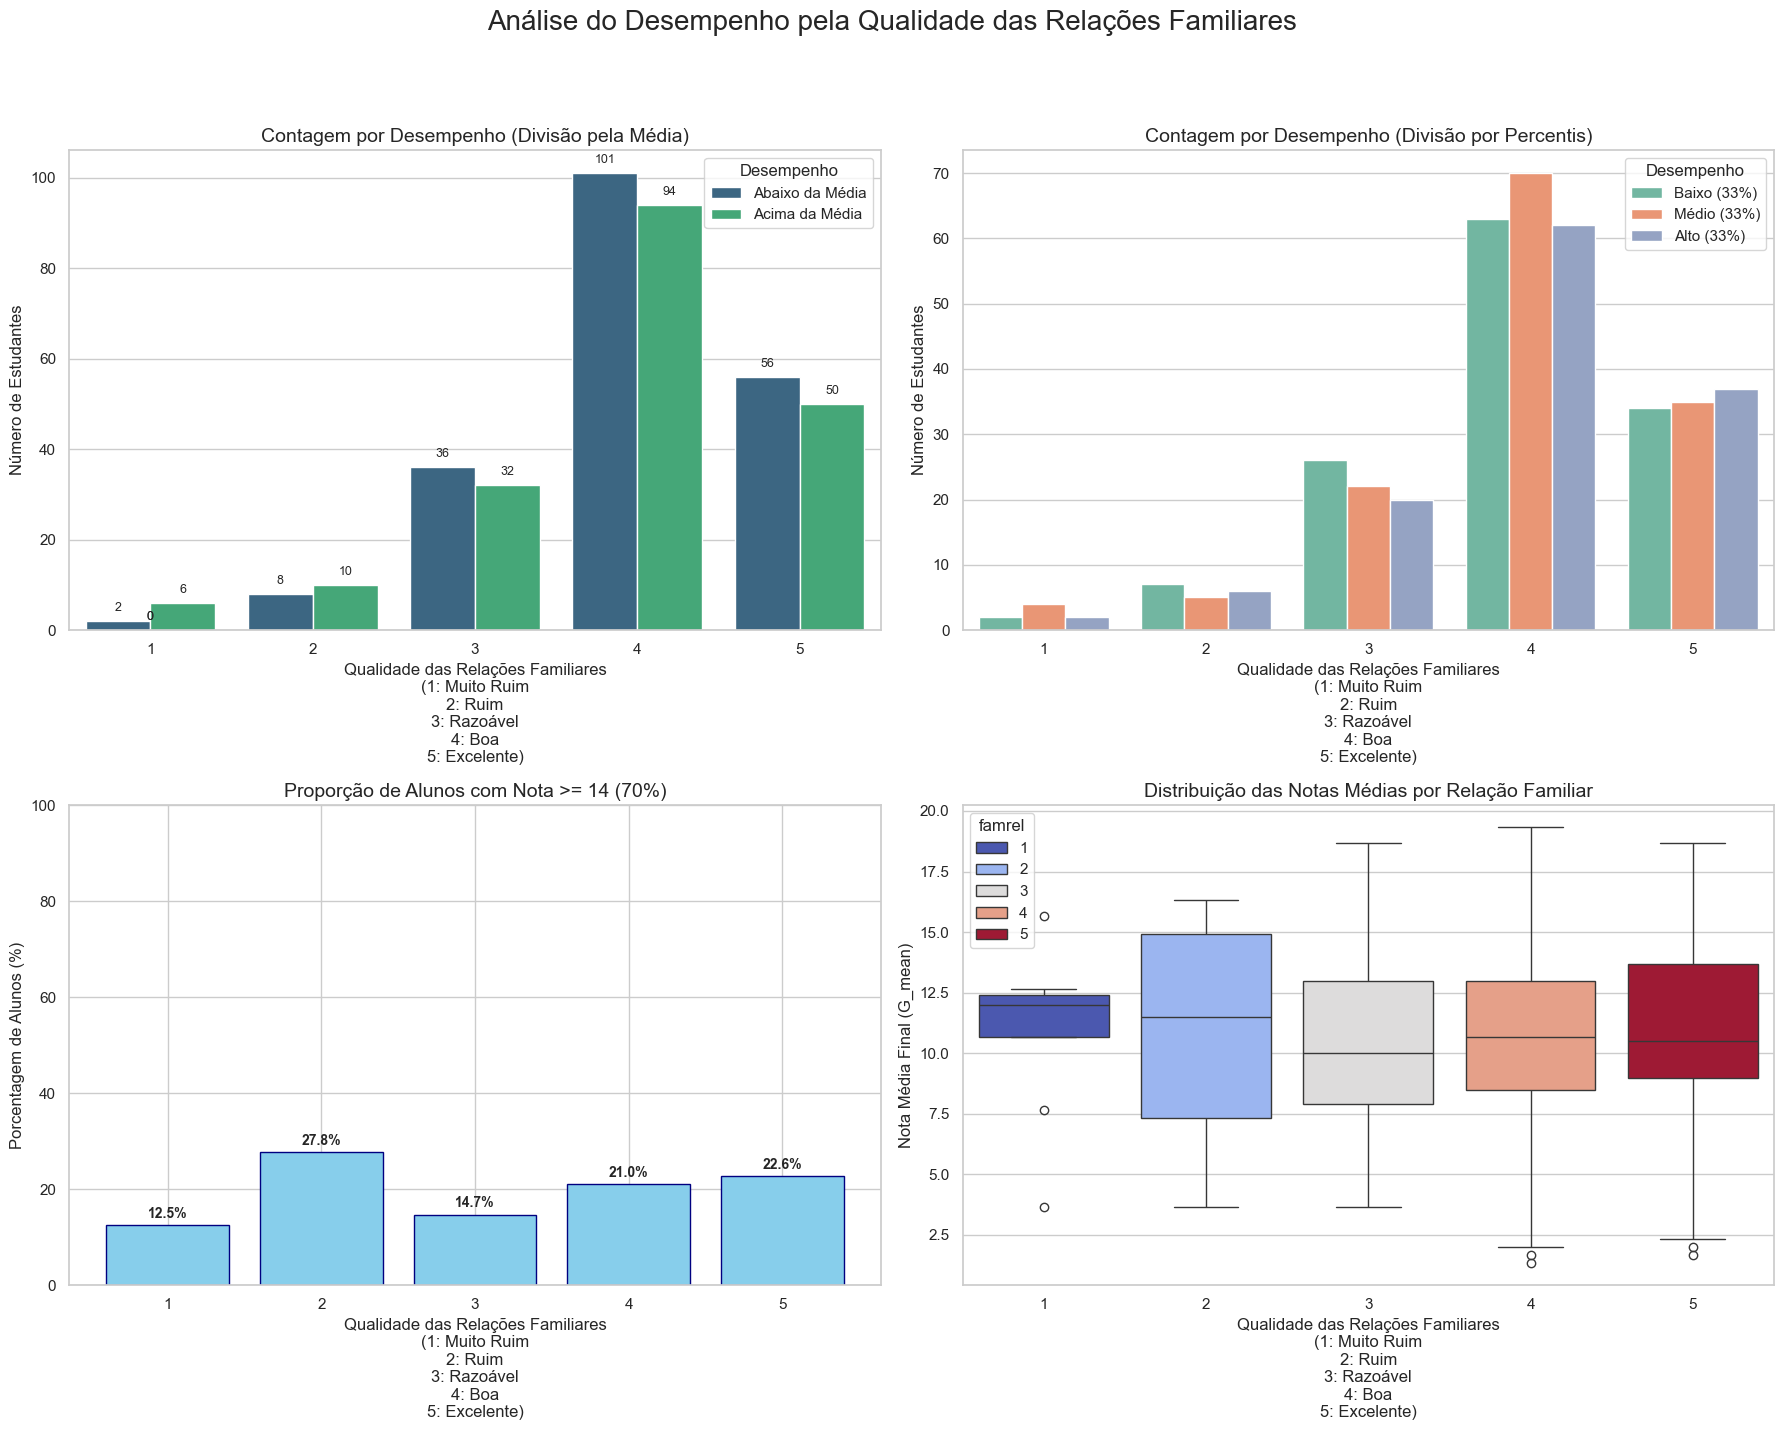

In [6]:
# Tabela descritiva
print("\n" + "="*60)
print("ANÁLISE 1: DISTRIBUIÇÃO PELA QUALIDADE DAS RELAÇÕES FAMILIARES")
print("="*60)

analise_famrel = df.groupby('famrel').agg({
    'G_mean': ['count', 'mean', 'std'],
    'acima_70_porcento': lambda x: (x == 'Sim').sum()
}).round(2)

analise_famrel.columns = ['Total_Alunos', 'Média_Notas', 'Desvio_Padrão', 'Qtd_Acima_70%']
analise_famrel['%_Acima_70%'] = (analise_famrel['Qtd_Acima_70%'] / analise_famrel['Total_Alunos'] * 100).round(1)
print(analise_famrel)

# Teste Qui-Quadrado para verificar a associação estatística
print("\n" + "="*60)
print("TESTE QUI-QUADRADO: RELAÇÕES FAMILIARES vs. DESEMPENHO")
print("="*60)

contingency_table = pd.crosstab(df['famrel'], df['desempenho_percentil'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Tabela de Contingência (Relações Familiares vs Desempenho por Percentil):")
print(contingency_table)
print(f"\nEstatística Qui-Quadrado: {chi2:.4f}")
print(f"Valor p: {p_value:.4f}")
print(f"Graus de liberdade: {dof}")

if p_value < 0.05:
    print("\n✅ Há uma associação ESTATISTICAMENTE SIGNIFICATIVA entre a qualidade das relações familiares e o desempenho do aluno (p < 0.05).")
else:
    print("\n❌ NÃO há associação significativa entre a qualidade das relações familiares e o desempenho do aluno (p ≥ 0.05).")


# --------------------------------------------------------------------------
# 3. VISUALIZAÇÕES
# Criação do painel de gráficos 2x2
# --------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análise do Desempenho pela Qualidade das Relações Familiares', fontsize=20, y=1.02)

# Rótulos do eixo X
famrel_labels = '1: Muito Ruim\n2: Ruim\n3: Razoável\n4: Boa\n5: Excelente'

# Gráfico 1: Contagem por Desempenho (Média Geral)
ax1 = axes[0, 0]
sns.countplot(data=df, x='famrel', hue='desempenho_media', ax=ax1, palette='viridis')
ax1.set_title('Contagem por Desempenho (Divisão pela Média)', fontsize=14)
ax1.set_xlabel(f'Qualidade das Relações Familiares\n({famrel_labels})', fontsize=12)
ax1.set_ylabel('Número de Estudantes', fontsize=12)
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=9, xytext=(0, 5), textcoords='offset points')
ax1.legend(title='Desempenho')

# Gráfico 2: Contagem por Desempenho (Percentis)
ax2 = axes[0, 1]
sns.countplot(data=df, x='famrel', hue='desempenho_percentil', ax=ax2, palette='Set2')
ax2.set_title('Contagem por Desempenho (Divisão por Percentis)', fontsize=14)
ax2.set_xlabel(f'Qualidade das Relações Familiares\n({famrel_labels})', fontsize=12)
ax2.set_ylabel('Número de Estudantes', fontsize=12)
ax2.legend(title='Desempenho')

# Gráfico 3: Proporção de Alunos com Nota Acima de 70%
ax3 = axes[1, 0]
prop_data = df.groupby('famrel')['acima_70_porcento'].apply(lambda x: (x == 'Sim').mean() * 100).fillna(0)
bars = ax3.bar(prop_data.index, prop_data.values, color='skyblue', edgecolor='navy')
ax3.set_title('Proporção de Alunos com Nota >= 14 (70%)', fontsize=14)
ax3.set_xlabel(f'Qualidade das Relações Familiares\n({famrel_labels})', fontsize=12)
ax3.set_ylabel('Porcentagem de Alunos (%)', fontsize=12)
ax3.set_ylim(0, 100)
for bar in bars:
    height = bar.get_height()
    ax3.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, weight='bold')

# Gráfico 4: Boxplot da Distribuição das Notas Médias
ax4 = axes[1, 1]
sns.boxplot(data=df, x='famrel', y='G_mean', hue='famrel', ax=ax4, palette='coolwarm')
ax4.set_title('Distribuição das Notas Médias por Relação Familiar', fontsize=14)
ax4.set_xlabel(f'Qualidade das Relações Familiares\n({famrel_labels})', fontsize=12)
ax4.set_ylabel('Nota Média Final (G_mean)', fontsize=12)

# Ajusta o layout para evitar sobreposição e exibe os gráficos
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('analise_relacoes_familiares.png', dpi=300, bbox_inches='tight')
plt.show()


ANÁLISE 1: DISTRIBUIÇÃO POR CONSUMO DE ÁLCOOL (SEMANA)
      Total_Alunos  Média_Notas  Desvio_Padrão  Qtd_Acima_70%  %_Acima_70%
Dalc                                                                      
1              276        10.95           3.83             68         24.6
2               75         9.86           3.62             10         13.3
3               26        10.54           2.84              3         11.5
4                9         9.81           2.40              0          0.0
5                9        10.63           2.47              0          0.0

TESTE QUI-QUADRADO: CONSUMO DE ÁLCOOL (SEMANA) vs. DESEMPENHO
Tabela de Contingência (Consumo de Álcool na Semana vs Desempenho por Percentil):
desempenho_percentil  Baixo (33%)  Médio (33%)  Alto (33%)
Dalc                                                      
1                              86           92          98
2                              30           26          19
3                              10     

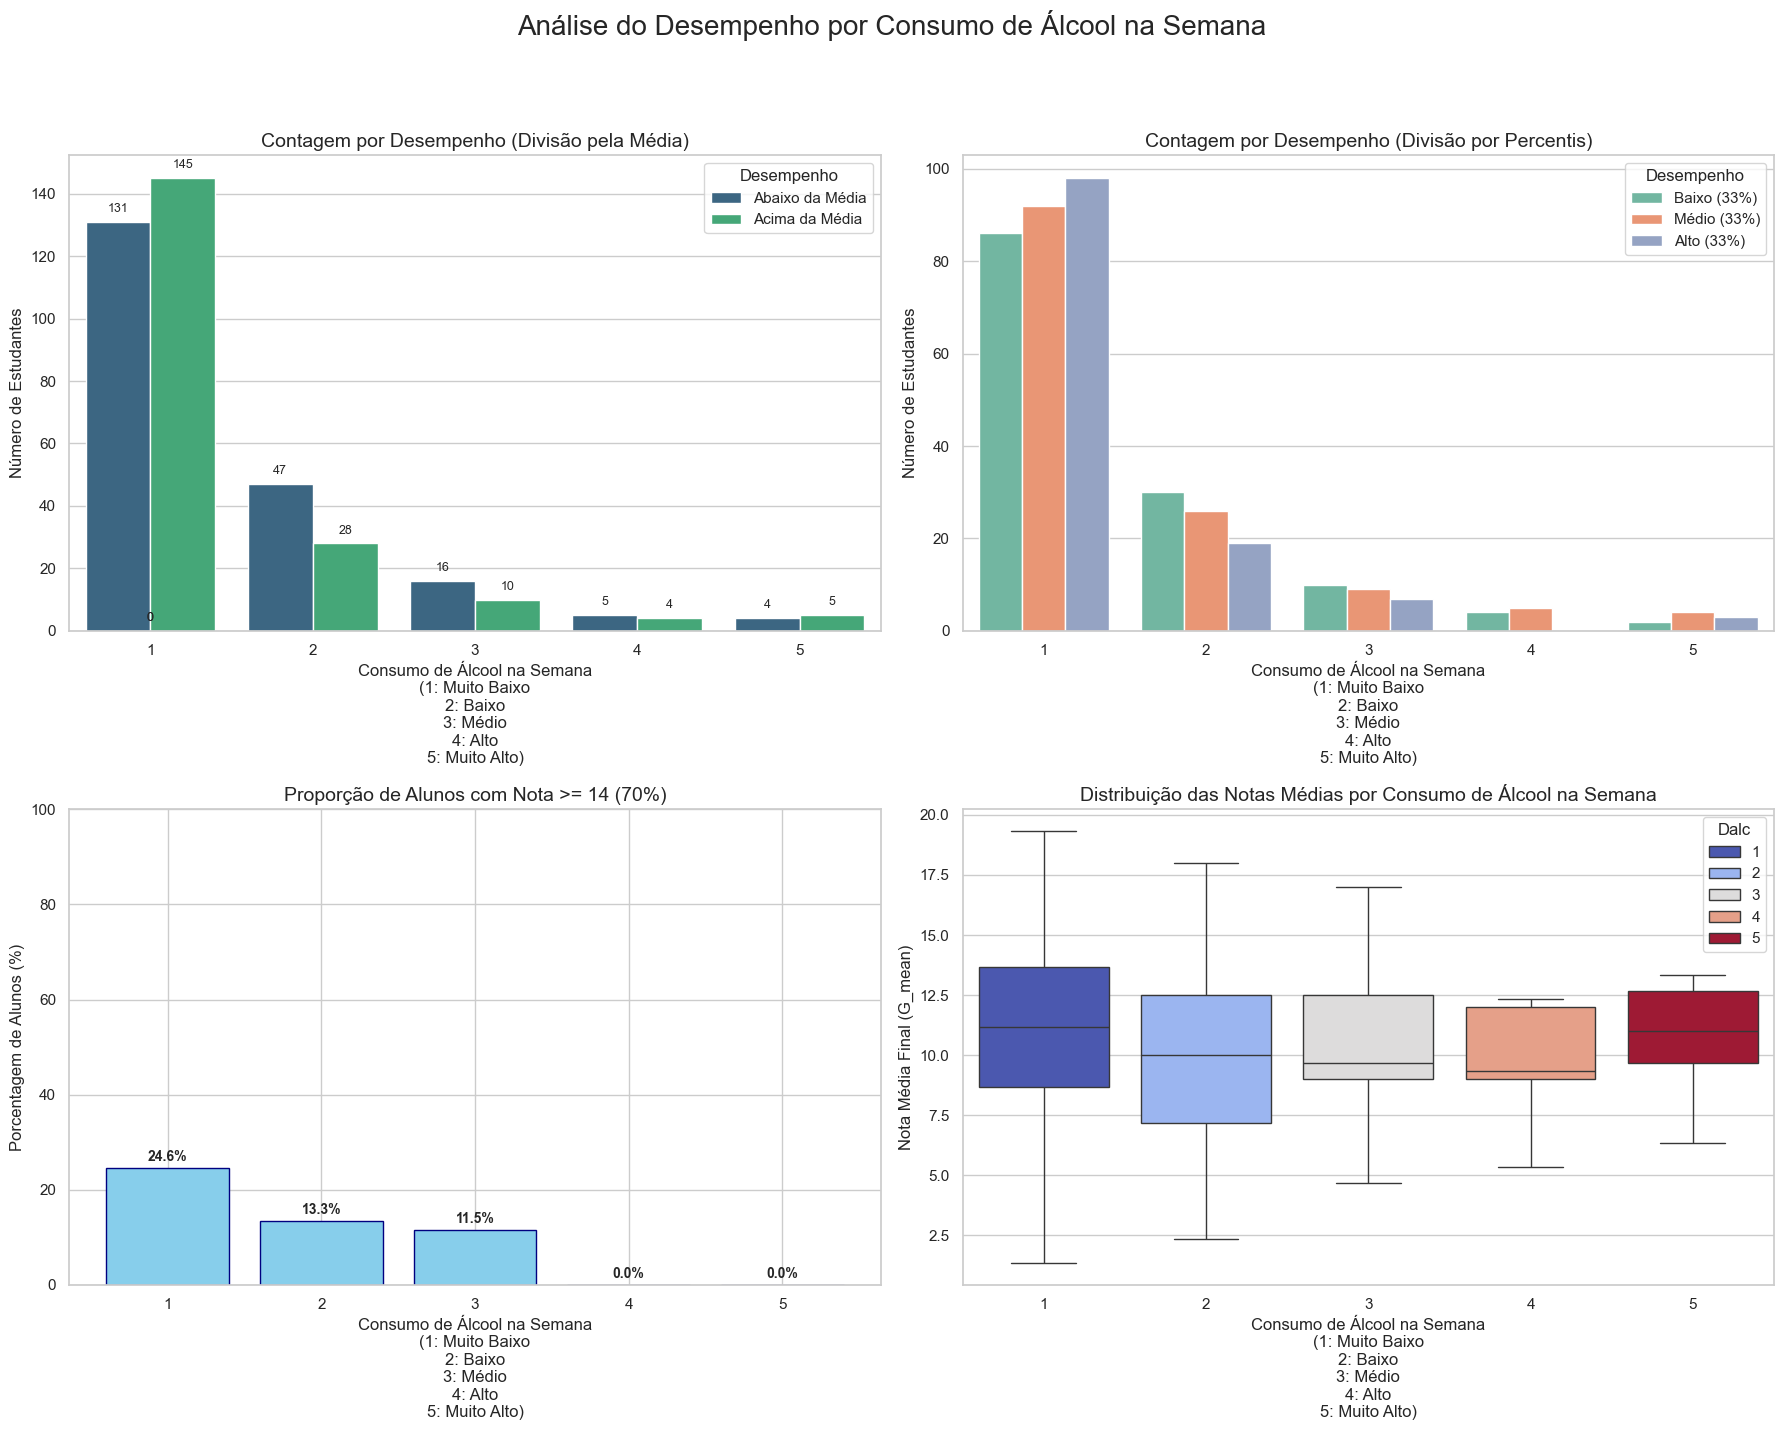

In [7]:
# Tabela descritiva
print("\n" + "="*60)
print("ANÁLISE 1: DISTRIBUIÇÃO POR CONSUMO DE ÁLCOOL (SEMANA)")
print("="*60)

analise_dalc = df.groupby('Dalc').agg({
    'G_mean': ['count', 'mean', 'std'],
    'acima_70_porcento': lambda x: (x == 'Sim').sum()
}).round(2)

analise_dalc.columns = ['Total_Alunos', 'Média_Notas', 'Desvio_Padrão', 'Qtd_Acima_70%']
analise_dalc['%_Acima_70%'] = (analise_dalc['Qtd_Acima_70%'] / analise_dalc['Total_Alunos'] * 100).round(1)
print(analise_dalc)

# Teste Qui-Quadrado para verificar a associação estatística
print("\n" + "="*60)
print("TESTE QUI-QUADRADO: CONSUMO DE ÁLCOOL (SEMANA) vs. DESEMPENHO")
print("="*60)

contingency_table = pd.crosstab(df['Dalc'], df['desempenho_percentil'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Tabela de Contingência (Consumo de Álcool na Semana vs Desempenho por Percentil):")
print(contingency_table)
print(f"\nEstatística Qui-Quadrado: {chi2:.4f}")
print(f"Valor p: {p_value:.4f}")
print(f"Graus de liberdade: {dof}")

if p_value < 0.05:
    print("\n✅ Há uma associação ESTATISTICAMENTE SIGNIFICATIVA entre o consumo de álcool na semana e o desempenho do aluno (p < 0.05).")
else:
    print("\n❌ NÃO há associação significativa entre o consumo de álcool na semana e o desempenho do aluno (p ≥ 0.05).")


# --------------------------------------------------------------------------
# 3. VISUALIZAÇÕES
# Criação do painel de gráficos 2x2
# --------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análise do Desempenho por Consumo de Álcool na Semana', fontsize=20, y=1.02)

# Rótulos do eixo X
dalc_labels = '1: Muito Baixo\n2: Baixo\n3: Médio\n4: Alto\n5: Muito Alto'

# Gráfico 1: Contagem por Desempenho (Média Geral)
ax1 = axes[0, 0]
sns.countplot(data=df, x='Dalc', hue='desempenho_media', ax=ax1, palette='viridis')
ax1.set_title('Contagem por Desempenho (Divisão pela Média)', fontsize=14)
ax1.set_xlabel(f'Consumo de Álcool na Semana\n({dalc_labels})', fontsize=12)
ax1.set_ylabel('Número de Estudantes', fontsize=12)
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=9, xytext=(0, 5), textcoords='offset points')
ax1.legend(title='Desempenho')

# Gráfico 2: Contagem por Desempenho (Percentis)
ax2 = axes[0, 1]
sns.countplot(data=df, x='Dalc', hue='desempenho_percentil', ax=ax2, palette='Set2')
ax2.set_title('Contagem por Desempenho (Divisão por Percentis)', fontsize=14)
ax2.set_xlabel(f'Consumo de Álcool na Semana\n({dalc_labels})', fontsize=12)
ax2.set_ylabel('Número de Estudantes', fontsize=12)
ax2.legend(title='Desempenho')

# Gráfico 3: Proporção de Alunos com Nota Acima de 70%
ax3 = axes[1, 0]
prop_data = df.groupby('Dalc')['acima_70_porcento'].apply(lambda x: (x == 'Sim').mean() * 100).fillna(0)
bars = ax3.bar(prop_data.index, prop_data.values, color='skyblue', edgecolor='navy')
ax3.set_title('Proporção de Alunos com Nota >= 14 (70%)', fontsize=14)
ax3.set_xlabel(f'Consumo de Álcool na Semana\n({dalc_labels})', fontsize=12)
ax3.set_ylabel('Porcentagem de Alunos (%)', fontsize=12)
ax3.set_ylim(0, 100)
for bar in bars:
    height = bar.get_height()
    ax3.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, weight='bold')

# Gráfico 4: Boxplot da Distribuição das Notas Médias
ax4 = axes[1, 1]
sns.boxplot(data=df, x='Dalc', y='G_mean', hue='Dalc', ax=ax4, palette='coolwarm')
ax4.set_title('Distribuição das Notas Médias por Consumo de Álcool na Semana', fontsize=14)
ax4.set_xlabel(f'Consumo de Álcool na Semana\n({dalc_labels})', fontsize=12)
ax4.set_ylabel('Nota Média Final (G_mean)', fontsize=12)

# Ajusta o layout para evitar sobreposição e exibe os gráficos
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('analise_consumo_alcool_semana.png', dpi=300, bbox_inches='tight')
plt.show()


ANÁLISE 1: DISTRIBUIÇÃO POR CONSUMO DE ÁLCOOL (FIM DE SEMANA)
      Total_Alunos  Média_Notas  Desvio_Padrão  Qtd_Acima_70%  %_Acima_70%
Walc                                                                      
1              151        10.99           4.07             38         25.2
2               85        10.65           3.82             19         22.4
3               80        10.86           3.23             16         20.0
4               51         9.81           3.11              5          9.8
5               28        10.15           3.34              3         10.7

TESTE QUI-QUADRADO: CONSUMO DE ÁLCOOL (FIM DE SEMANA) vs. DESEMPENHO
Tabela de Contingência (Consumo de Álcool no Fim de Semana vs Desempenho por Percentil):
desempenho_percentil  Baixo (33%)  Médio (33%)  Alto (33%)
Walc                                                      
1                              50           46          55
2                              26           28          31
3                

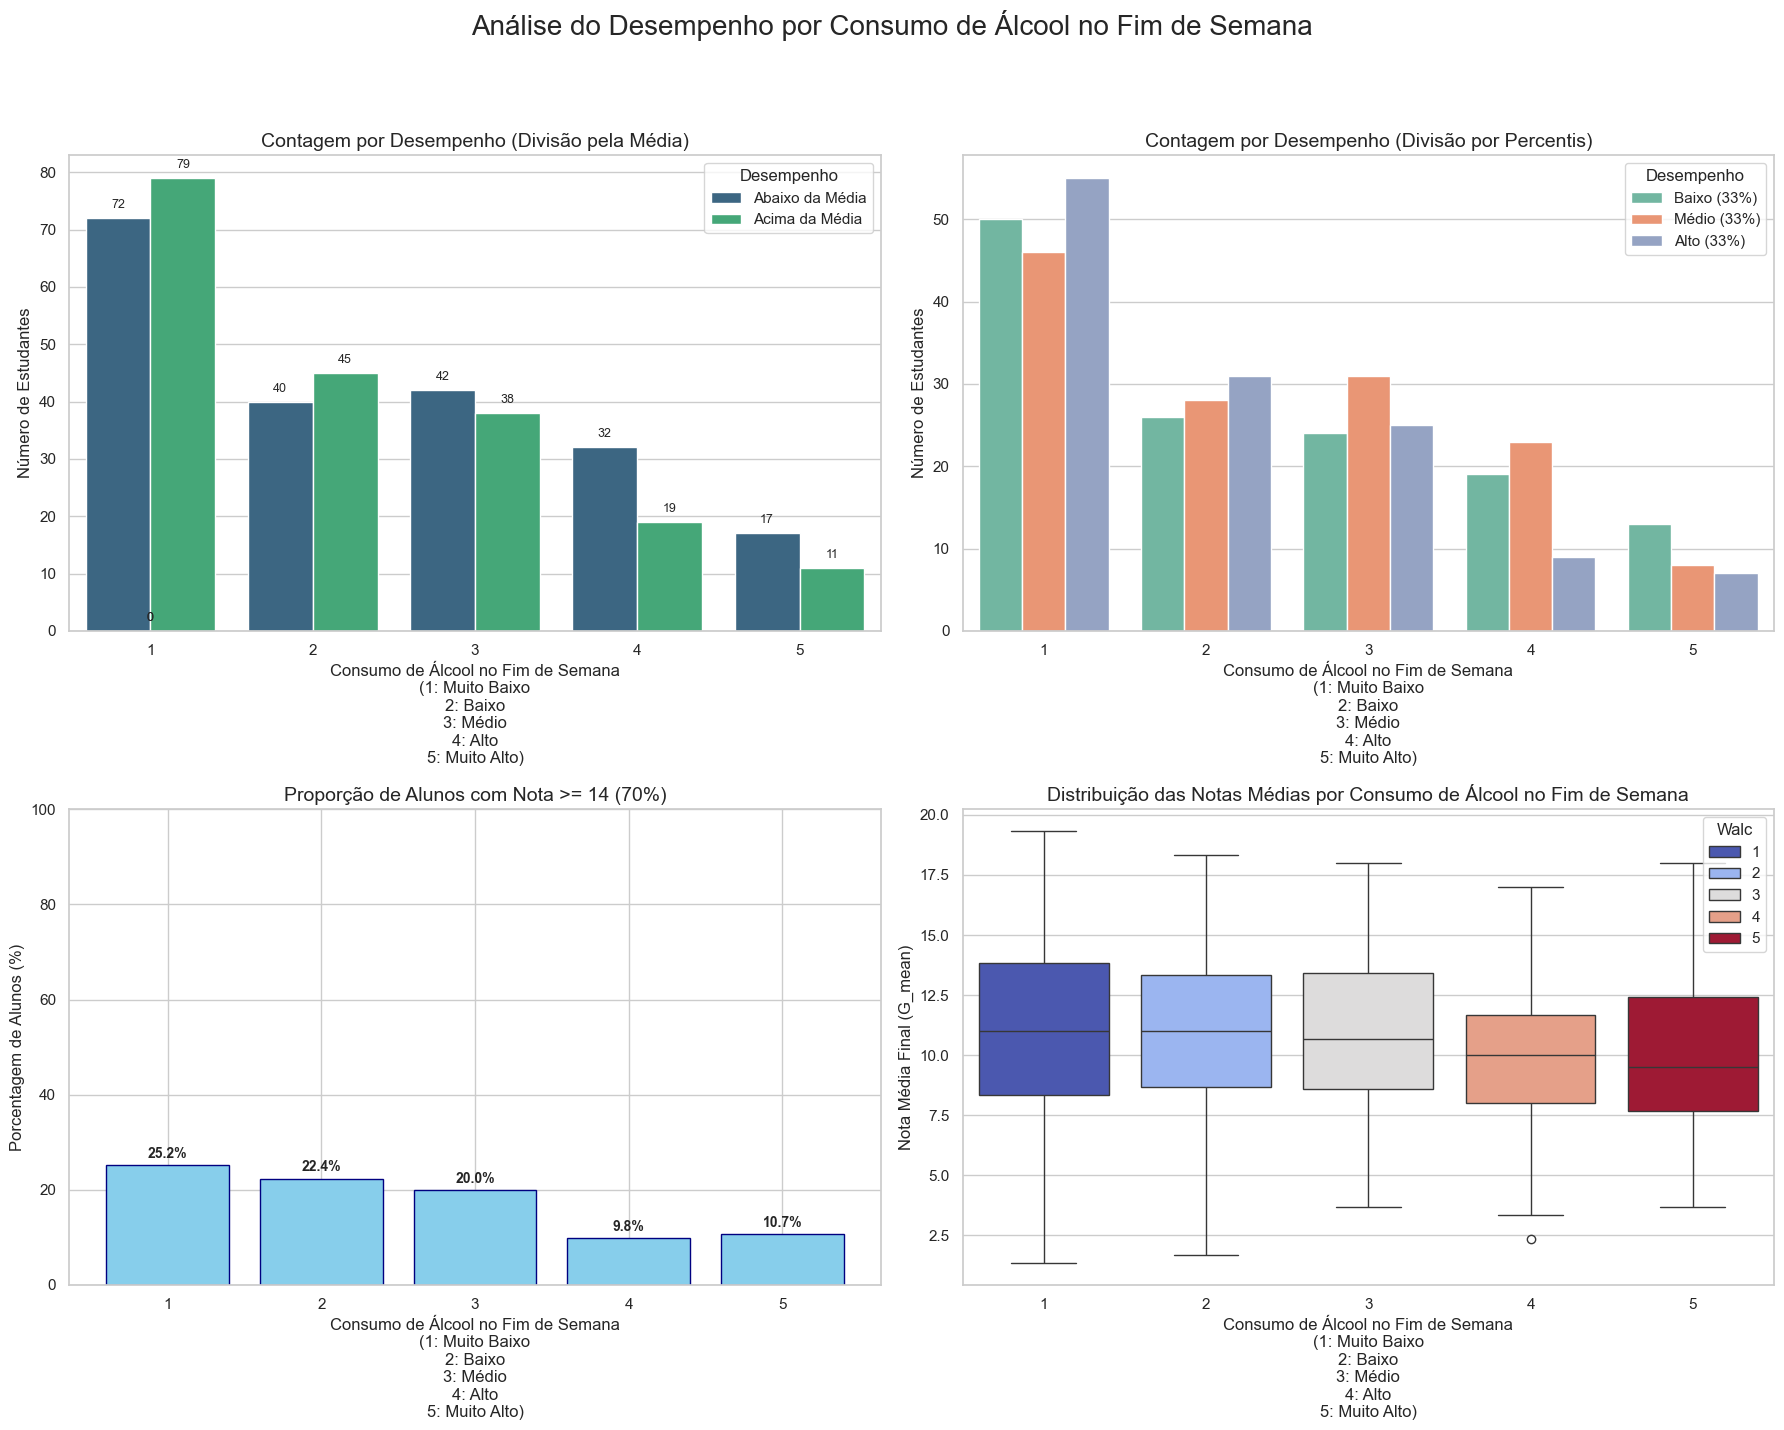

In [8]:
# Tabela descritiva
print("\n" + "="*60)
print("ANÁLISE 1: DISTRIBUIÇÃO POR CONSUMO DE ÁLCOOL (FIM DE SEMANA)")
print("="*60)

analise_walc = df.groupby('Walc').agg({
    'G_mean': ['count', 'mean', 'std'],
    'acima_70_porcento': lambda x: (x == 'Sim').sum()
}).round(2)

analise_walc.columns = ['Total_Alunos', 'Média_Notas', 'Desvio_Padrão', 'Qtd_Acima_70%']
analise_walc['%_Acima_70%'] = (analise_walc['Qtd_Acima_70%'] / analise_walc['Total_Alunos'] * 100).round(1)
print(analise_walc)

# Teste Qui-Quadrado para verificar a associação estatística
print("\n" + "="*60)
print("TESTE QUI-QUADRADO: CONSUMO DE ÁLCOOL (FIM DE SEMANA) vs. DESEMPENHO")
print("="*60)

contingency_table = pd.crosstab(df['Walc'], df['desempenho_percentil'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Tabela de Contingência (Consumo de Álcool no Fim de Semana vs Desempenho por Percentil):")
print(contingency_table)
print(f"\nEstatística Qui-Quadrado: {chi2:.4f}")
print(f"Valor p: {p_value:.4f}")
print(f"Graus de liberdade: {dof}")

if p_value < 0.05:
    print("\n✅ Há uma associação ESTATISTICAMENTE SIGNIFICATIVA entre o consumo de álcool no fim de semana e o desempenho do aluno (p < 0.05).")
else:
    print("\n❌ NÃO há associação significativa entre o consumo de álcool no fim de semana e o desempenho do aluno (p ≥ 0.05).")


# --------------------------------------------------------------------------
# 3. VISUALIZAÇÕES
# Criação do painel de gráficos 2x2
# --------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análise do Desempenho por Consumo de Álcool no Fim de Semana', fontsize=20, y=1.02)

# Rótulos do eixo X
walc_labels = '1: Muito Baixo\n2: Baixo\n3: Médio\n4: Alto\n5: Muito Alto'

# Gráfico 1: Contagem por Desempenho (Média Geral)
ax1 = axes[0, 0]
sns.countplot(data=df, x='Walc', hue='desempenho_media', ax=ax1, palette='viridis')
ax1.set_title('Contagem por Desempenho (Divisão pela Média)', fontsize=14)
ax1.set_xlabel(f'Consumo de Álcool no Fim de Semana\n({walc_labels})', fontsize=12)
ax1.set_ylabel('Número de Estudantes', fontsize=12)
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=9, xytext=(0, 5), textcoords='offset points')
ax1.legend(title='Desempenho')

# Gráfico 2: Contagem por Desempenho (Percentis)
ax2 = axes[0, 1]
sns.countplot(data=df, x='Walc', hue='desempenho_percentil', ax=ax2, palette='Set2')
ax2.set_title('Contagem por Desempenho (Divisão por Percentis)', fontsize=14)
ax2.set_xlabel(f'Consumo de Álcool no Fim de Semana\n({walc_labels})', fontsize=12)
ax2.set_ylabel('Número de Estudantes', fontsize=12)
ax2.legend(title='Desempenho')

# Gráfico 3: Proporção de Alunos com Nota Acima de 70%
ax3 = axes[1, 0]
prop_data = df.groupby('Walc')['acima_70_porcento'].apply(lambda x: (x == 'Sim').mean() * 100).fillna(0)
bars = ax3.bar(prop_data.index, prop_data.values, color='skyblue', edgecolor='navy')
ax3.set_title('Proporção de Alunos com Nota >= 14 (70%)', fontsize=14)
ax3.set_xlabel(f'Consumo de Álcool no Fim de Semana\n({walc_labels})', fontsize=12)
ax3.set_ylabel('Porcentagem de Alunos (%)', fontsize=12)
ax3.set_ylim(0, 100)
for bar in bars:
    height = bar.get_height()
    ax3.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, weight='bold')

# Gráfico 4: Boxplot da Distribuição das Notas Médias
ax4 = axes[1, 1]
sns.boxplot(data=df, x='Walc', y='G_mean', hue='Walc', ax=ax4, palette='coolwarm')
ax4.set_title('Distribuição das Notas Médias por Consumo de Álcool no Fim de Semana', fontsize=14)
ax4.set_xlabel(f'Consumo de Álcool no Fim de Semana\n({walc_labels})', fontsize=12)
ax4.set_ylabel('Nota Média Final (G_mean)', fontsize=12)

# Ajusta o layout para evitar sobreposição e exibe os gráficos
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('analise_consumo_alcool_fds.png', dpi=300, bbox_inches='tight')
plt.show()